In [1]:
import ROOT, rat
import os, sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
sys.path.append('/home/jp/projects/python_tools')
import jp_mpl as jplot
import rat

TClass::TClass:0: RuntimeWarning: no dictionary for class omtext is available


In [2]:
def getNorm(v):
    return v/np.sqrt(np.sum(v**2))
def renormN(n, axis=0):
    n+= 1E-9

    integral = np.sum(n,axis=axis)
    if axis==0:
        return n/integral
    else:
        return (n.T/integral).T

In [3]:
infile_dir = '/home/jp/projects/snoplus/rundir/greydisc_validation/onepmt_geo'


In [4]:
infile_name = 'thebox.root'

In [5]:
try:
    ratreader.close()
    print 'Closing file before reopenning'
except:
    print 'No ratreader file. Opening it for the first time'
fname = os.path.join(infile_dir, infile_name)
if os.path.isfile(fname): print 'File exists'
ratreader = rat.dsreader(fname)

No ratreader file. Opening it for the first time
File exists


In [6]:
def doRead(single = False):
    photons_steps = [] # List of tracks
    photons_p     = []
    photons_ids   = []
    volumes       = []
    process       = []
    for ds, run in ratreader:
        mymc = ds.GetMC()
        for itrack in range(1, mymc.GetMCTrackCount()+1):
            mytrack = mymc.GetMCTrack(itrack)
            
            # End here to study the info in a track
            if single:
                return mytrack
            
            volumes.append([])
            process.append([])
            photons_steps.append(np.zeros(3))
            photons_p.append(np.zeros(3))
            
            photons_ids.append(mytrack.GetTrackID())
            
            #if pdg_code != 22: 
            #    # Particle is not a gamma
            #    continue
            
            for istep in range(mymc.GetMCTrack(itrack).GetMCTrackStepCount()):
                photons_steps[-1] = np.vstack((photons_steps[-1], np.zeros(3)))
                photons_p[-1] = np.vstack((photons_p[-1], np.zeros(3)))

                mystep = mymc.GetMCTrack(itrack).GetMCTrackStep(istep)
                position = mystep.GetPosition()
                momentum = mystep.GetMomentum()
                position.GetXYZ(photons_steps[-1][-1,:])
                momentum.GetXYZ(photons_p[-1][-1,:])
                process[-1].append(mystep.GetProcess())
                volumes[-1].append(mystep.GetEndVolume())

                
    ratreader.close()
    
    hcvalue = 1.239841 # eV*um (electronvolts times micrometer)
    
    return photons_steps, photons_p, volumes, \
           process, np.array(photons_ids)

In [7]:
r = doRead(single = True)

In [8]:
pos, mom, volumes,proc, ids = doRead()

In [9]:
# Need only those that are reflected from the PMT ... so I need at least 2 steps, right?

In [10]:
# Following a photon
index = 0
print 'Position'
print pos[index]
print 'Momentum'
print mom[index]
print 'End volume'
print volumes[index]
print 'Processes'
print proc[index]
print 'Track ID'
print ids[index]


Position
[[   0.            0.            0.        ]
 [  61.           89.11883545  -99.20651245]
 [  62.20000076   81.63193512 -105.43378448]
 [  64.84317017   65.14096069 -119.15024567]
 [  64.88302612   64.89231873 -119.35705566]
 [  64.88302612   64.89231873 -119.35705566]
 [  64.90209961   64.56761932 -119.35333252]
 [  64.90238953   64.5626297  -119.35327148]
 [  64.90238953   64.5626297  -119.35327148]
 [  72.61012268  -66.65378571 -117.84812927]
 [  72.62757111  -66.95080566 -117.84471893]
 [  72.62757111  -66.95080566 -117.84471893]]
Momentum
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  3.03306280e-07  -1.89235425e-06  -1.57397619e-06]
 [  3.03306280e-07  -1.89235425e-06  -1.57397619e-06]
 [  3.03306280e-07  -1.89235425e-06  -1.57397619e-06]
 [  3.03306280e-07  -1.89235425e-06  -1.57397619e-06]
 [  1.45416507e-07  -2.47557023e-06   2.83965793e-08]
 [  1.45416507e-07  -2.47557023e-06   2.83965793e-08]
 [  1.45416507e-07  -2.47557023e-06   2.83965793e-08]
 [  1.454

In [11]:
# The particles that end up in NULL made it out of the PMT
# If the momentum in x in the second step is negative it goes away from the PMT
# Positive momentum goes towards the PMT -- done

# I put the zeros there myself, dont look at them
# If the length of end volume or processes is 2, then the particle wasnt reflected
# If the last volume is the 'r_1408_pmt' then the particle as absorbed
# Gotta be careful with reflections from the outside of the PMT volume ... 
# These reflections wouldn't be a problem if I could put a cylindrical cap instead of the box
# Easy fix: only take photons that are emitted within the radius of the concentrator (see gdisc radius)
# Last momentum needs to have negative x
# End volume needs to be NULL
# Re-run with a smaller world to avoid scattering in the water ... also, change to heavy water

In [12]:
good_pos = []
good_mom = []
all_volumes = []
all_proc = []
gdisc_radius = 137.7
for iPhoton in range(len(pos)):
    # Look at px of step 1 (step 0 is zero by construction) - only take positives
    if mom[iPhoton][1][0] < 0:
        continue

    # Last step needs to be going outwards
    if mom[iPhoton][-1][0] > 0:
        continue

    # Calculate the radius at emission point, only take those starting within the gdisc radius 
    r = np.sqrt(np.sum(pos[iPhoton][1][1:]**2))
    if r > gdisc_radius:
        continue
        
    if volumes[iPhoton][-1] != 'NULL':
        continue
        
    # Keep all these photons
    # I could do my operations here, but I'll store them for now
    good_pos.append(pos[iPhoton])
    good_mom.append(mom[iPhoton])
    all_volumes.append(volumes[iPhoton])
    all_proc.append(proc[iPhoton])

In [13]:
len(good_pos)

163918

In [14]:
# Output a file
# y, z, theta, phi, out_theta, out_phi
keys = ['nsteps', 'y','z','theta_i', 'phi_i','theta_f','phi_f']
data = {}
for iKey in keys:
    data[iKey] = np.zeros(len(good_pos))

normal = np.array([-1, 0, 0])

for iPhoton in range(len(good_pos)):
    data['y'][iPhoton] = good_pos[iPhoton][1][1]
    data['z'][iPhoton] = good_pos[iPhoton][1][2]
    
    # The negative value is because the theta is negative - otherwise I would need to correct for it later
    data['theta_i'][iPhoton] = np.arccos(np.dot(normal, -getNorm(good_mom[iPhoton][1])))
    
    # The phi is obtained 
    data['phi_i'][iPhoton]   = np.arctan2(good_mom[iPhoton][1][2],
                               good_mom[iPhoton][1][1])
    
    data['theta_f'][iPhoton] = np.arccos(np.dot(normal, getNorm(good_mom[iPhoton][-1])))
    
    # This is not correct, should be momentum
    data['phi_f'][iPhoton]   = np.arctan2(good_mom[iPhoton][-1][2], 
                                   good_mom[iPhoton][-1][1])
    
    data['nsteps'][iPhoton] = len(good_pos[iPhoton])

In [15]:
data['r'] = np.sqrt(data['y']**2 + data['z']**2)
phidiff = (data['phi_f'] - data['phi_i'])
phidiff[phidiff<0] += np.pi*2
data['phidiff'] = phidiff

In [16]:
phidiff = data['phi_f'] - data['phi_i']

In [17]:
print data['phi_i'][:10]
print data['phi_f'][:10]


[-2.19138192 -1.24299355 -0.96947172  0.85451219 -2.77345778 -0.03470872
 -1.82706052 -0.42903695  2.93472459  2.69455839]
[ 1.49291346  1.94110282  0.58168418  1.91937834  2.78528739  0.68581738
  1.82047193 -3.06483944 -0.47257953 -1.46452581]


In [108]:
import pickle
pickle.dump(data, open('/home/jp/projects/snoplus/rundir/greydisc_validation/onepmt_geo/condensed.pckl','w'))

In [53]:
# Some tests for the interpretation
normal = np.array([1,0,0])
incoming = np.array([-1., 0, 0])
#outgoing = np.array([1., 0, -0.5])
dot = np.dot(normal, -getNorm(incoming))
print dot, np.rad2deg(np.arccos(dot))
#print 104-90, 76-90

1.0 0.0


In [88]:
np.rad2deg(data['phidiff'].max())

359.99999874108329

In [84]:
data.keys()

['theta_f', 'phidiff', 'theta_i', 'y', 'r', 'phi_f', 'phi_i', 'z']

###  Start here if you have already loaded/selected the tracks

In [3]:
import pickle
data = pickle.load(open('/home/jp/projects/snoplus/rundir/greydisc_validation/onepmt_geo/condensed.pckl'))


In [119]:
# Change the theta to do it as a function of cos(theta) - it might show up more interesting correlations
gdr = 138.
def plotReflections(data, sel):
    fig = plt.figure(figsize=(16,14))

    ### First figure - incoming vs diff
    ax1 = fig.add_subplot(221)

    x1 = np.linspace(0, np.pi/2., 41)
    x2 = np.linspace(-np.pi/2, np.pi/2., 51)
    n, x1, x2 = np.histogram2d(data['theta_i'][sel], 
                               data['theta_f'][sel] - data['theta_i'][sel], 
                               [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(np.rad2deg(x1),
               np.rad2deg(x2),
               n.T)
    plt.xlabel('Incoming theta (deg)')
    plt.ylabel('theta_f - theta_i (deg)')
    plt.colorbar()
    plt.title('Outgoing theta - incoming')
    #plt.yticks(np.arange(-90, 90, 5.0))

    
    
    ### Second figure - function of radius
    ax2 = fig.add_subplot(222)
    x1 = np.linspace(0, gdr, 41)
    x2 = np.linspace(-np.pi/2, np.pi/2., 51)
    n, x1, x2 = np.histogram2d(data['r'][sel], 
                               data['theta_f'][sel] - data['theta_i'][sel], 
                               [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(x1,
               np.rad2deg(x2),
               n.T)
    plt.xlabel('Radius (mm)')
    plt.ylabel('theta_f - theta_i (deg)')
    plt.colorbar()
    plt.title('Theta difference vs radius')
    
    
    ### Third figure - cos(theta) incoming vs outgoing
    ax3 = fig.add_subplot(223)
    x1 = np.linspace(0, 1., 41)
    x2 = np.linspace(-1, 1., 51)
    n, x1, x2 = np.histogram2d(np.cos(data['theta_i'][sel]), 
                               np.cos(data['theta_f'][sel])-\
                               np.cos(data['theta_i'][sel]), 
                               [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(x1,
               x2,
               n.T)
    plt.xlabel('cos(theta_i)')
    plt.ylabel('cos(theta_f) - cos(theta_i)')
    plt.colorbar()
    plt.title('Outgoing theta vs radius')  
    
    # Fourth figure - function of contact position
    ax4 = fig.add_subplot(224)
    iev  = 500
    prob = iev*1./len(sel)
    randsel = sel*(np.random.rand(len(sel)) < prob)
    plt.quiver(data['y'][randsel], 
               data['z'][randsel],
               np.cos(data['theta_f'][randsel]), 
               np.sin(data['phi_f'][randsel]))
    plt.xlabel('y (mm)')
    plt.ylabel('z (mm)')

    plt.title('Outgoing theta vs radius') 
    
    
    

    # New figure - everything for phi
    fig2 = plt.figure(figsize=(16,14))

    
    ### Figure
    axb = fig2.add_subplot(221)

    x1 = np.linspace(-np.pi, np.pi, 41)
    x2 = np.linspace(0, np.pi*2, 51)
    n, x1, x2 = np.histogram2d(data['phi_i'][sel], 
                               data['phidiff'][sel], [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(np.rad2deg(x1),
               np.rad2deg(x2),
               n.T)
    plt.xlabel('Incoming phi (deg)')
    plt.ylabel('phi_f - phi_i (deg)')
    plt.colorbar()
    plt.title('Outgoing phi - incoming')

    
    ## Phi change vs radius
    axb2 = fig2.add_subplot(222)
    x1 = np.linspace(0, 138., 41)
    x2 = np.linspace(0, np.pi*2, 51)
    n, x1, x2 = np.histogram2d(data['r'][sel], 
                               data['phidiff'][sel], 
                               [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(x1,
               np.rad2deg(x2),
               n.T)
    plt.xlabel('Radius (mm)')
    plt.ylabel('phi_f - phi_i (deg)')
    plt.colorbar()
    plt.title('Phi difference vs radius')
    
    # Phi change vs incoming theta
    axb3 = fig2.add_subplot(223)
    x1 = np.linspace(0, np.pi/2., 41)
    x2 = np.linspace(0, np.pi*2, 51)
    n, x1, x2 = np.histogram2d(data['theta_i'][sel], 
                               data['phidiff'][sel], 
                               [x1,x2])
    n = renormN(n,axis=1)
    plt.pcolor(np.rad2deg(x1),
               np.rad2deg(x2),
               n.T)
    plt.xlabel('Incoming theta (deg)')
    plt.ylabel('phi_f - phi_i (deg)')
    plt.colorbar()
    plt.title('Phi difference vs incoming theta')    
    
    # Outpgoing phi as function of radius
    axb4 = fig2.add_subplot(224)

    
    # outgoing phi as a function of radius?
    plt.title('Change in phi vs radius')
    iev  = 500
    prob = iev*1./len(sel)
    randsel = sel*(np.random.rand(len(sel)) < prob)
    plt.quiver(data['y'][randsel], 
               data['z'][randsel],
               np.cos(data['phi_f'][randsel] - data['phi_i'][randsel]), 
               np.sin(data['phi_f'][randsel] - data['phi_i'][randsel]))
    plt.xlabel('y (mm)')
    plt.ylabel('z (mm)')

Selecting all the events


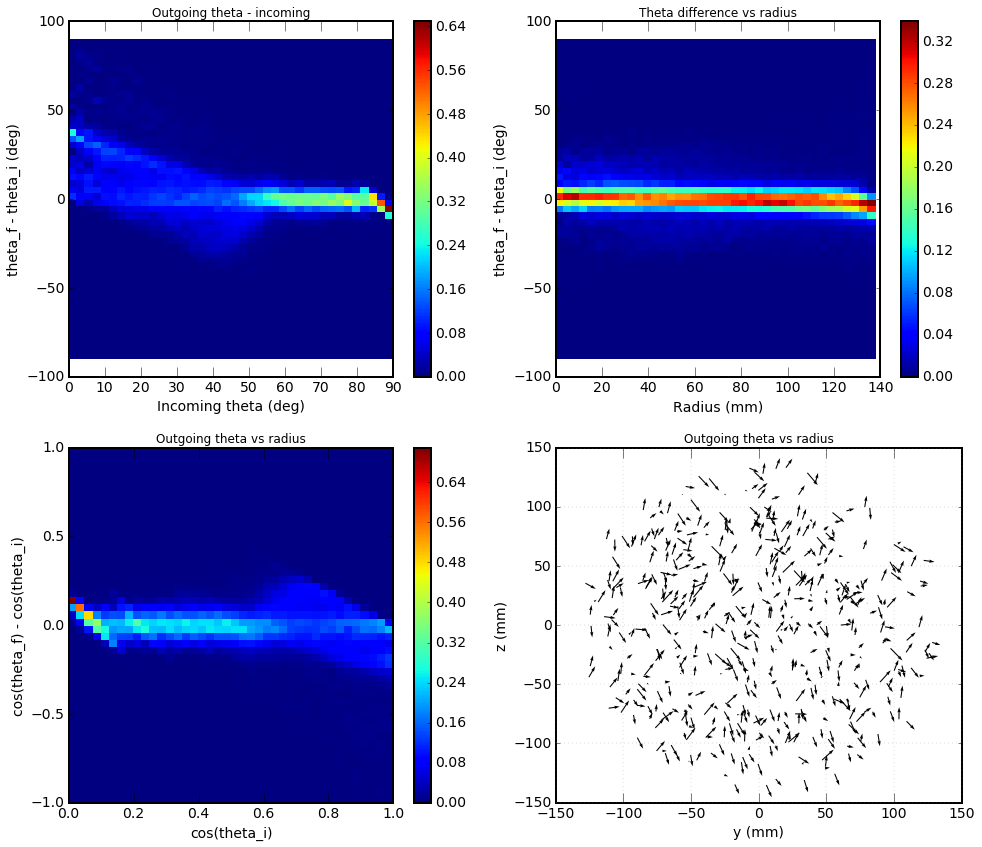

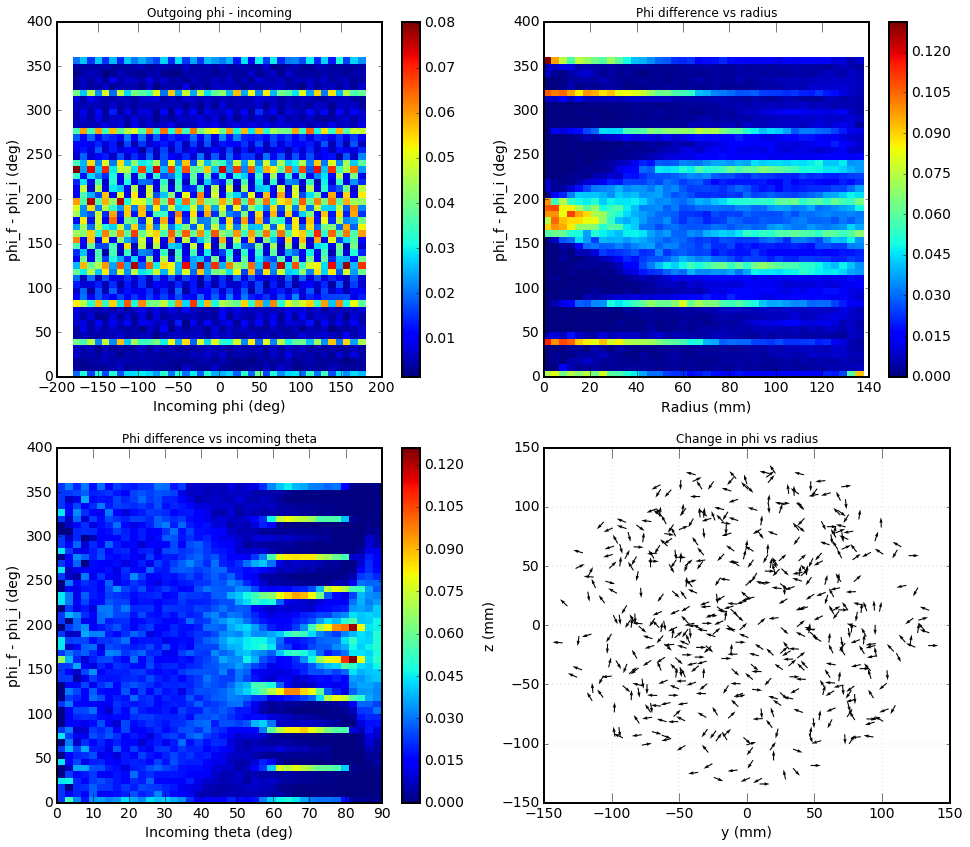

In [120]:
print 'Selecting all the events'
sel=( np.array([True]*len(data['y']))
     #*(data['y'] > 0)
     #*(data['z'] > 0)
     #*(data['r']>0)
    )
plotReflections(data,sel)


Selecting the inner part and very small theta_i (bringing the specular reflection back)


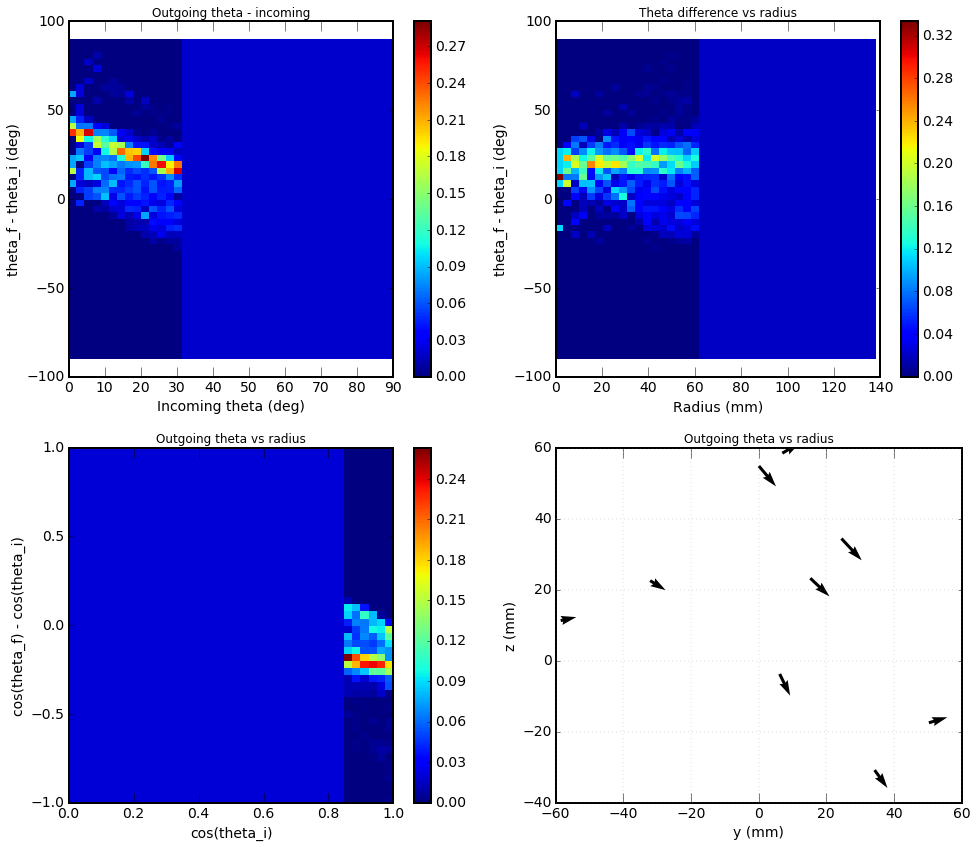

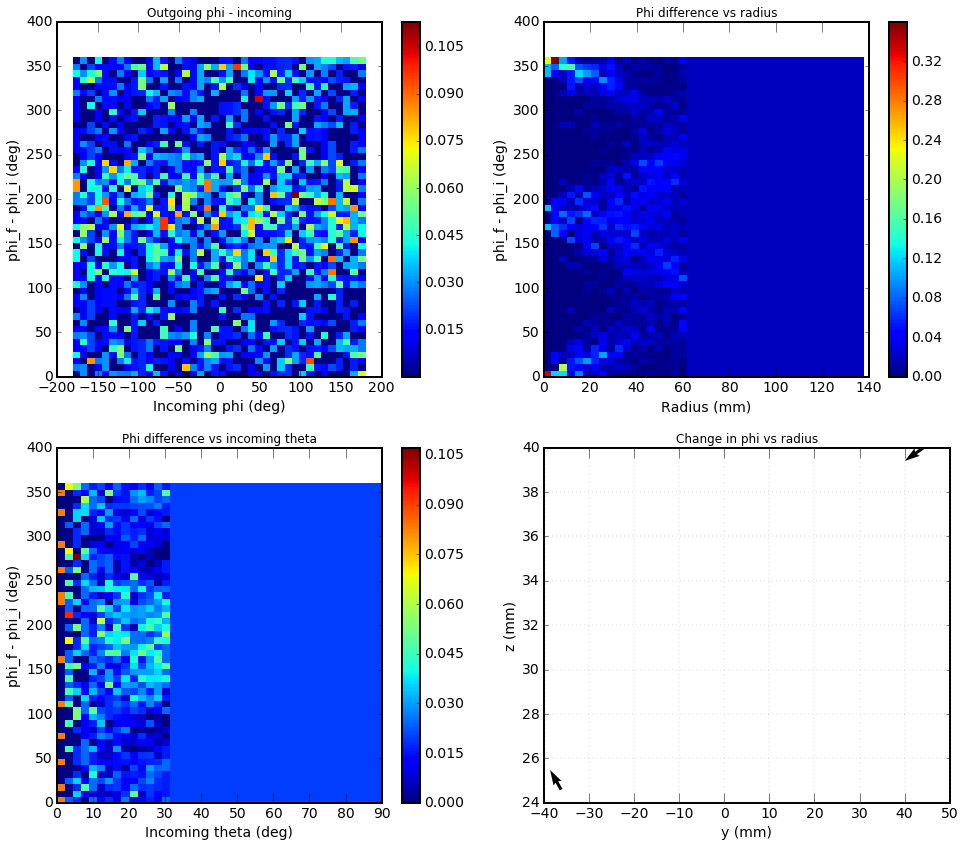

In [306]:
print 'Selecting the inner part and very small theta_i (bringing the specular reflection back)'
sel=( np.array([True]*len(data['y']))
     *(data['theta_i'] < np.deg2rad(30.))
     *(data['r'] <60.)
     #*(data['z'] > 0)
     #*(data['r']>0)
    )
plotReflections(data,sel)


Selecting the outer rim and very small theta_i (bringing the specular reflection back)


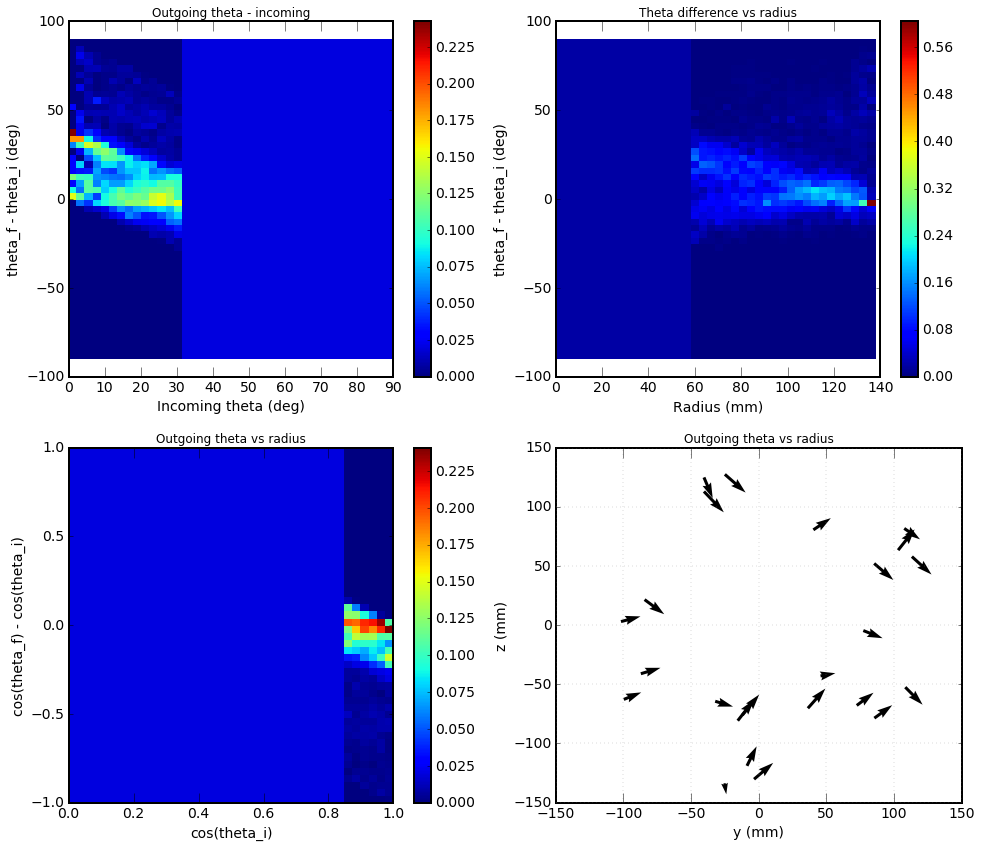

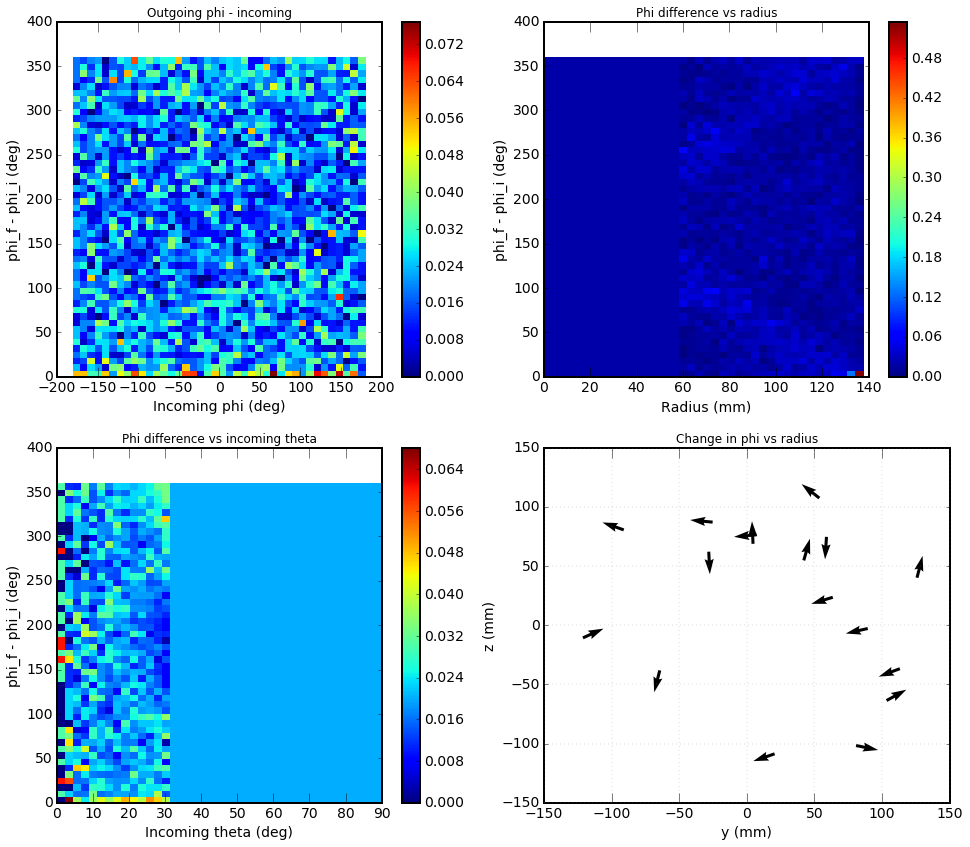

In [311]:
print 'Selecting the outer rim and very small theta_i (bringing the specular reflection back)'
sel=( np.array([True]*len(data['y']))
     *(data['theta_i'] < np.deg2rad(30.))
     *(data['r'] > 60.)
     #*(data['z'] > 0)
     #*(data['r']>0)
    )
plotReflections(data,sel)


Large angles, outer radius


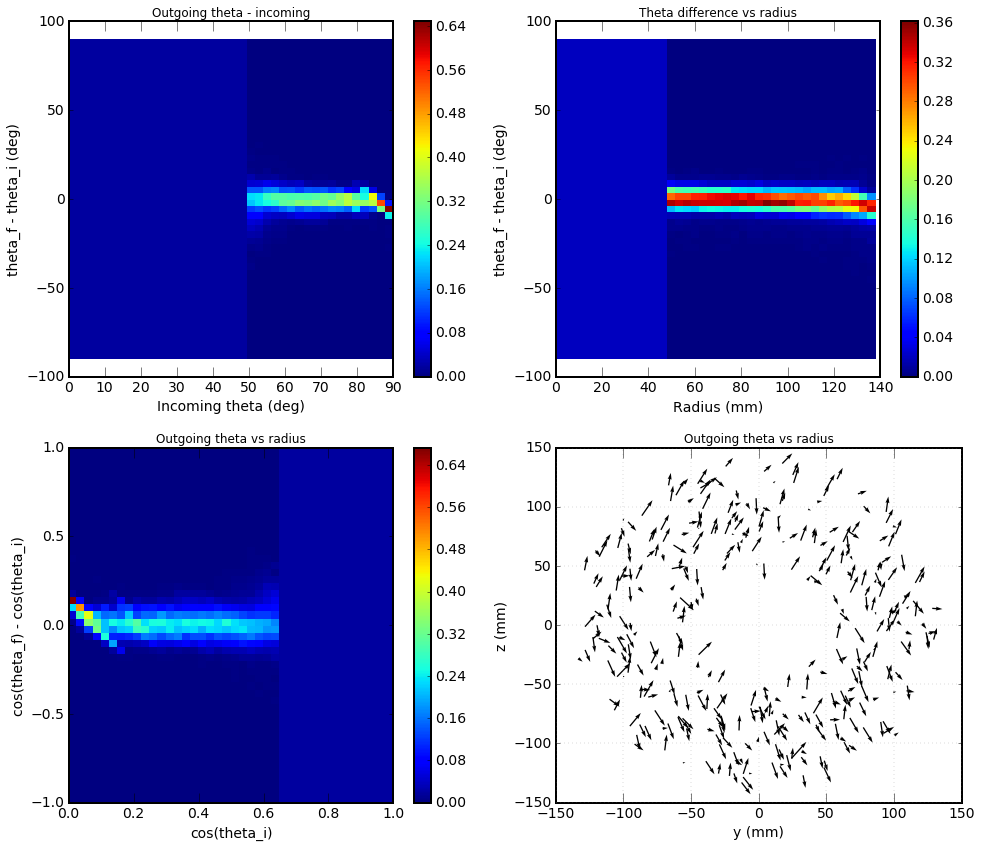

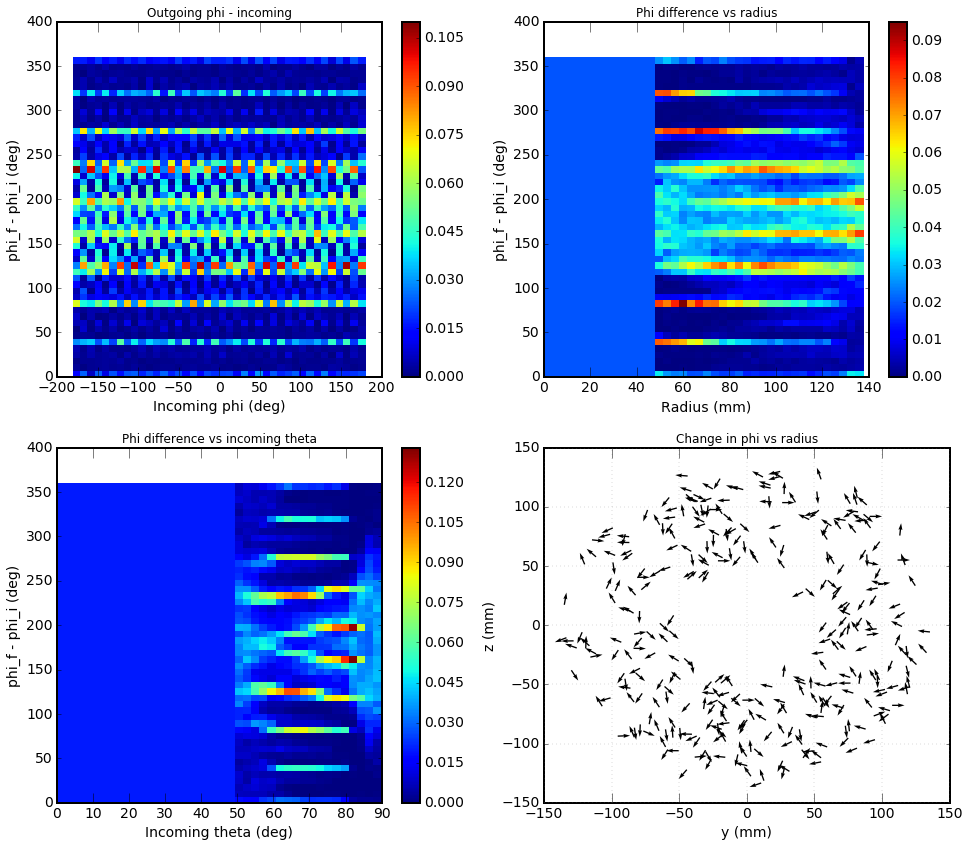

In [122]:
print 'Large angles, outer radius'
sel=( np.array([True]*len(data['y']))
     *(data['theta_i'] > np.deg2rad(50.))
     *(data['r'] > 50.)
     #*(data['z'] > 0)
     #*(data['r']>0)
    )
plotReflections(data,sel)


Mean -0.745488245911 std 7.58820021256
Mean -0.672535280716 std 5.00009961151
Mean -0.78361272746 std 4.45843507488
Mean -1.59651351406 std 4.6692220357


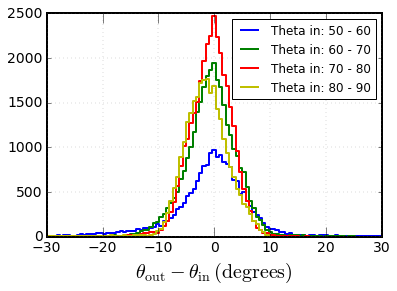

In [146]:
from itertools import cycle
colors = cycle(['b','g','r','y','m','c'])
xaxis = np.linspace(-30,30, 102)

inregions = [50,60,70,80,90]
for i in range(len(inregions)-1):
    sel=( np.array([True]*len(data['y']))
         *(data['theta_i'] > np.deg2rad(inregions[i]))
         *(data['theta_i'] < np.deg2rad(inregions[i+1]))
         *(data['r'] > 50.)
         #*(data['z'] > 0)
         #*(data['r']>0)
        )
    thisdata = np.rad2deg(data['theta_f'] - data['theta_i'])[sel]
    bins, x = np.histogram(thisdata, xaxis)
    print 'Mean', thisdata.mean(), 'std', thisdata.std()
    jplot.unfilledBar(x,bins, color=colors.next(), 
                      label = 'Theta in: %02i' % inregions[i] + ' - %02i' % inregions[i+1])
    
plt.legend(loc=0)
plt.xlabel(r'$\theta_\mathrm{out} - \theta_\mathrm{in}\,\mathrm{(degrees)}$', fontsize=20)

Mean 21.0224274189 std 13.9343705907
Mean 6.07679475276 std 15.9830516141
Mean -0.88448554311 std 10.3649274318


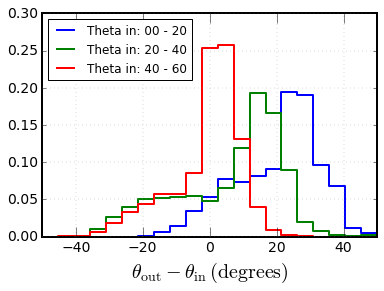

In [170]:
from itertools import cycle
colors = cycle(['b','g','r','y','m','c'])
xaxis = np.linspace(-50,50, 22)

inregions = [0,  20,  40, 60]
for i in range(len(inregions)-1):
    sel=( np.array([True]*len(data['y']))
         *(data['theta_i'] > np.deg2rad(inregions[i]))
         *(data['theta_i'] < np.deg2rad(inregions[i+1]))
         *(data['r'] < 60.)
         #*(data['z'] > 0)
         #*(data['r']>0)
        )    

    thisdata = np.rad2deg(data['theta_f'] - data['theta_i'])[sel]
    bins, x = np.histogram(thisdata, xaxis)
    print 'Mean', thisdata.mean(), 'std', thisdata.std()
    jplot.unfilledBar(x,bins*1./np.sum(bins), color=colors.next(), 
                      label = 'Theta in: %02i' % inregions[i] + ' - %02i' % inregions[i+1])
    
plt.legend(loc=0)
plt.xlabel(r'$\theta_\mathrm{out} - \theta_\mathrm{in}\,\mathrm{(degrees)}$', fontsize=20)

In [228]:
# TODO: implement argparse to get parameters
p0 = [300.0, 215.0, 10.0, 50.0, 272.0, 15.0]
from scipy import optimize
gaus = lambda x, normalization, mean, sigma: normalization * np.exp(-0.5 * (x - mean)**2 / sigma**2)
two_gaus = lambda x, n1, m1, s1, n2, m2, s2: gaus(x, n1, m1, s1) + gaus(x, n2, m2, s2)


Factor 27.0

Mu1 -0.0995924988663 std1 3.93869679602
Mu2 -9.85661206121 std2 16.3939374152
[  0.09391173  -0.0995925    3.9386968    0.05140702  -9.85661206
  16.39393742]
Factor 15.0

Mu1 1.06056439309 std1 5.91264339767
Mu2 -25.7131675777 std2 13.4844635184
[  0.12050108   1.06056439   5.9126434    0.03598515 -25.71316758
  13.48446352]
Factor 3.0

Mu1 0.200120780325 std1 4.20400399814
Mu2 -9.06764031496 std2 15.1709501616
[  0.15788079   0.20012078   4.204004     0.03656644  -9.06764031
  15.17095016]


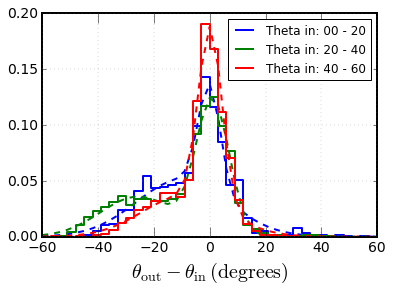

In [257]:
colors = cycle(['b','g','r','y','m','c'])
#xaxis = np.linspace(-2,2, 41)
xaxis = np.linspace(-60,60, 41)

inregions = [0,  20,  40, 60]
for i in range(len(inregions)-1):
    sel=( np.array([True]*len(data['y']))
         *(data['theta_i'] > np.deg2rad(inregions[i]))
         *(data['theta_i'] < np.deg2rad(inregions[i+1]))
         *(data['r'] < 60.)
         #*(data['z'] > 0)
         #*(data['r']>0)
        )    
    
    corrtheta = (inregions[i]+inregions[i+1])/2.
    corrfactor = -0.6*corrtheta+33.
    print 'Factor', corrfactor

    thisdata = np.rad2deg((data['theta_f'] - data['theta_i']))[sel]-corrfactor
    #thisdata = np.rad2deg(data['theta_f'] - data['theta_i'])[sel]

    
    #print thisdata.min(), thisdata.max()
    bins, x = np.histogram(thisdata, xaxis)
    #print 'Mean', thisdata.mean(), 'std', thisdata.std()
    #tmpdata = np.concatenate((thisdata[thisdata>0], -1.*thisdata[thisdata>0]))
    #print 'STD2', tmpdata.std()
    
    # Fitting two gaussians
    p0 = [0.15, 0, 8, 0.15, -15, 20]
    fit_fcn = two_gaus
    xfit = np.array([0.5 * (x[k] + x[k + 1]) for k in range(len(bins))])
    
    
    bins = bins*1./np.sum(bins)
    
    popt, pcov = optimize.curve_fit(fit_fcn, xfit, bins, p0 = p0)
    
    print '\nMu1', popt[1], 'std1', popt[2]
    print 'Mu2', popt[4], 'std2', popt[5]
    print popt
    
    thiscolor= colors.next()
    
    plt.plot(x, fit_fcn(x, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5]),
             color=thiscolor, linestyle = '--')
    
    jplot.unfilledBar(x, bins, color=thiscolor, 
                      label = 'Theta in: %02i' % inregions[i] + ' - %02i' % inregions[i+1])
    
plt.legend(loc=0)
plt.xlabel(r'$\theta_\mathrm{out} - \theta_\mathrm{in}\,\mathrm{(degrees)}$', fontsize=20)

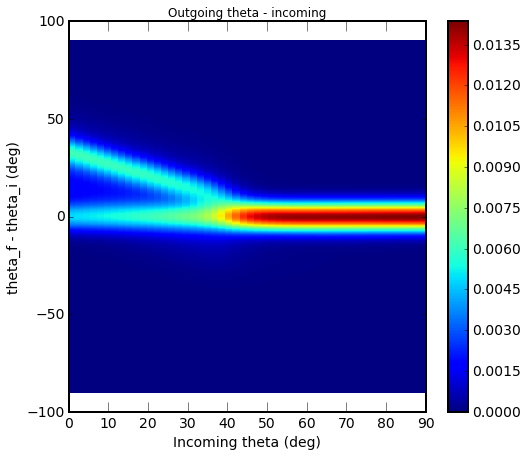

In [301]:
y = np.linspace(-90, 90, 1000.)

in_theta = np.linspace(0, 90, 51)

output = np.zeros([len(in_theta), len(y)])


weighting_fcn = -np.arctan((in_theta-40)/5.)
weighting_fcn -= weighting_fcn.min()
weighting_fcn *= 0.7/weighting_fcn.max()

for i in range(len(in_theta)):

    
    wpmt = weighting_fcn[i]
    wspec = 1-weighting_fcn[i]

        
        
    specular_reflection = gaus(y, 0.15, 0., 5)

    corrfactor = -0.6*in_theta[i]+33.
    pmt_reflection = two_gaus(y-corrfactor, 0.13, 0., 5., 0.05, -10, 15.)#-corrfactor

    pmt_reflection      *= wpmt/np.sum(pmt_reflection)
    specular_reflection *= wspec/np.sum(specular_reflection)

    total = pmt_reflection + specular_reflection
        
    # Need to weight one against the other - basically, at 50 degrees the reflection should disappear
    # 50/50 between 0 and 55

    #plt.plot(y, pmt_reflection)
    #plt.plot(y, specular_reflection)
    #plt.show()
    #raw_input()
    output[i,:] = total
    
    

fig = plt.figure(figsize=(16/2.,14/2.))

plt.xlabel('Incoming theta (deg)')
plt.ylabel('theta_f - theta_i (deg)')
plt.title('Outgoing theta - incoming')
plt.pcolor(in_theta, y, output.T)
plt.colorbar()


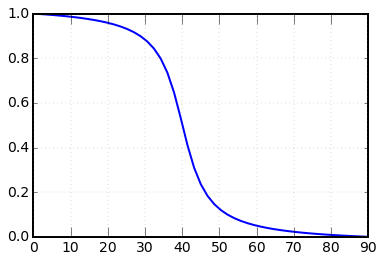

In [294]:
weighting_fcn = -np.arctan((in_theta-40)/5.)
weighting_fcn -= weighting_fcn.min()
weighting_fcn /= weighting_fcn.max()
plt.plot(in_theta, weighting_fcn)

Mean -0.168590802663 std 0.131942157795
Mean -0.0835996534093 std 0.149308772695
Mean -0.00377764908872 std 0.1185850196
This is the cosine of the angles


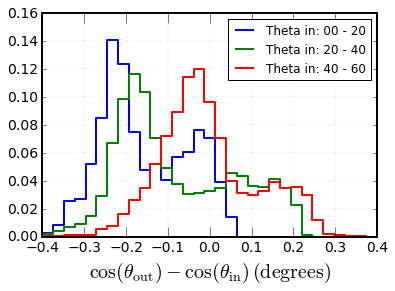

In [173]:
from itertools import cycle
colors = cycle(['b','g','r','y','m','c'])
xaxis = np.linspace(-0.4,0.4, 32)

inregions = [0,  20,  40, 60]
for i in range(len(inregions)-1):
    sel=( np.array([True]*len(data['y']))
         *(data['theta_i'] > np.deg2rad(inregions[i]))
         *(data['theta_i'] < np.deg2rad(inregions[i+1]))
         *(data['r'] < 60.)
         #*(data['z'] > 0)
         #*(data['r']>0)
        )    
    thisdata = (np.cos(data['theta_f']) - np.cos(data['theta_i']))[sel]
    bins, x = np.histogram(thisdata, xaxis)
    print 'Mean', thisdata.mean(), 'std', thisdata.std()
    jplot.unfilledBar(x,bins*1./np.sum(bins), color=colors.next(), 
                      label = 'Theta in: %02i' % inregions[i] + ' - %02i' % inregions[i+1])
    
print 'This is the cosine of the angles'
plt.legend(loc=0)
plt.xlabel(r'$\cos(\theta_\mathrm{out}) - \cos(\theta_\mathrm{in})\,\mathrm{(degrees)}$', fontsize=20)

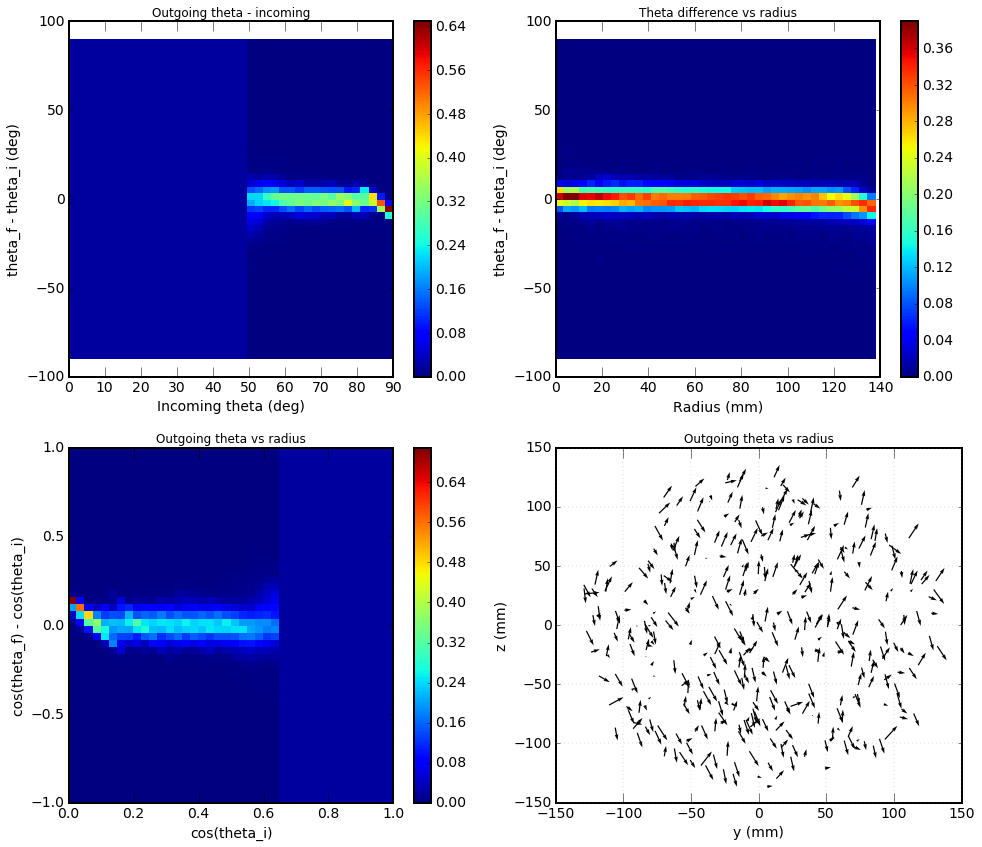

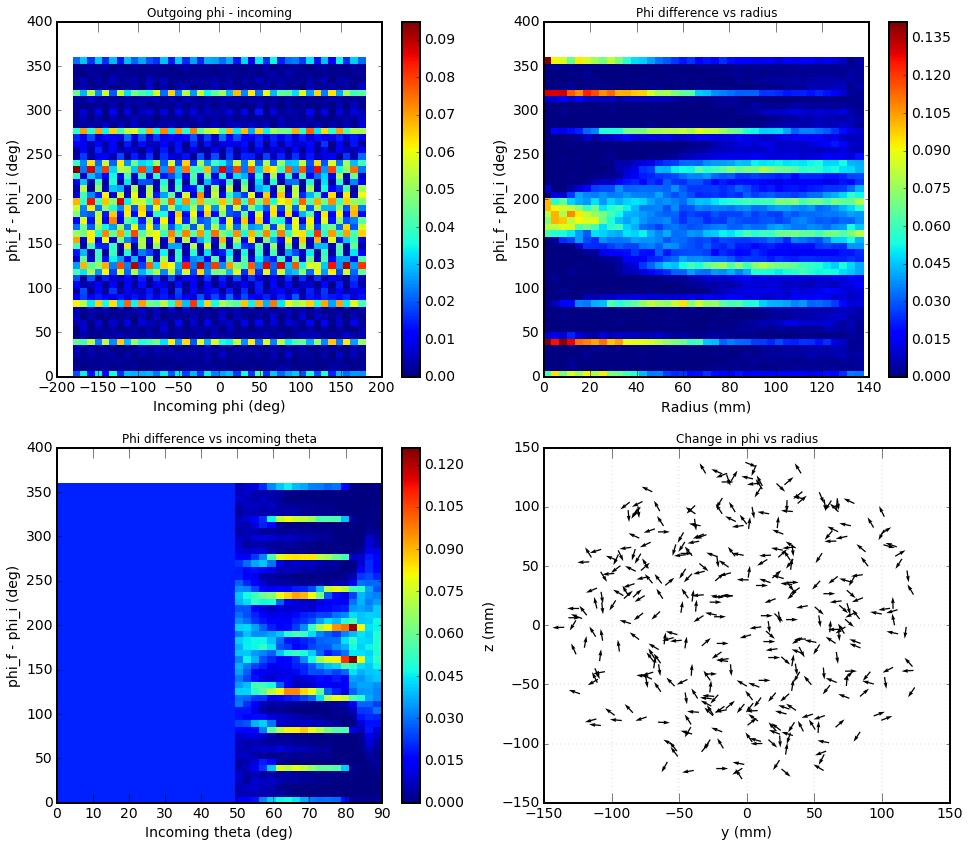

In [312]:
# Let's plot the outgoing theta as a function of incoming theta
sel=( np.array([True]*len(data['y']))
     *(data['theta_i'] > np.deg2rad(50.))
     #*(data['z'] > 0)
     #*(data['r']>0)
    )
plotReflections(data,sel)


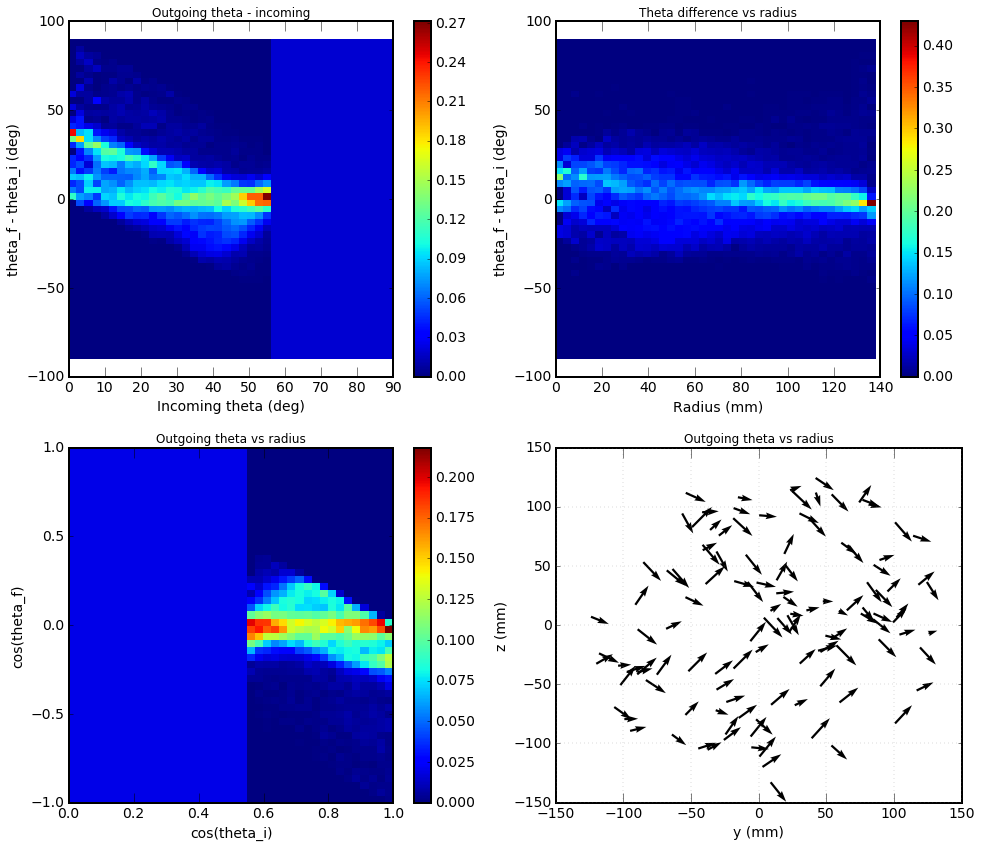

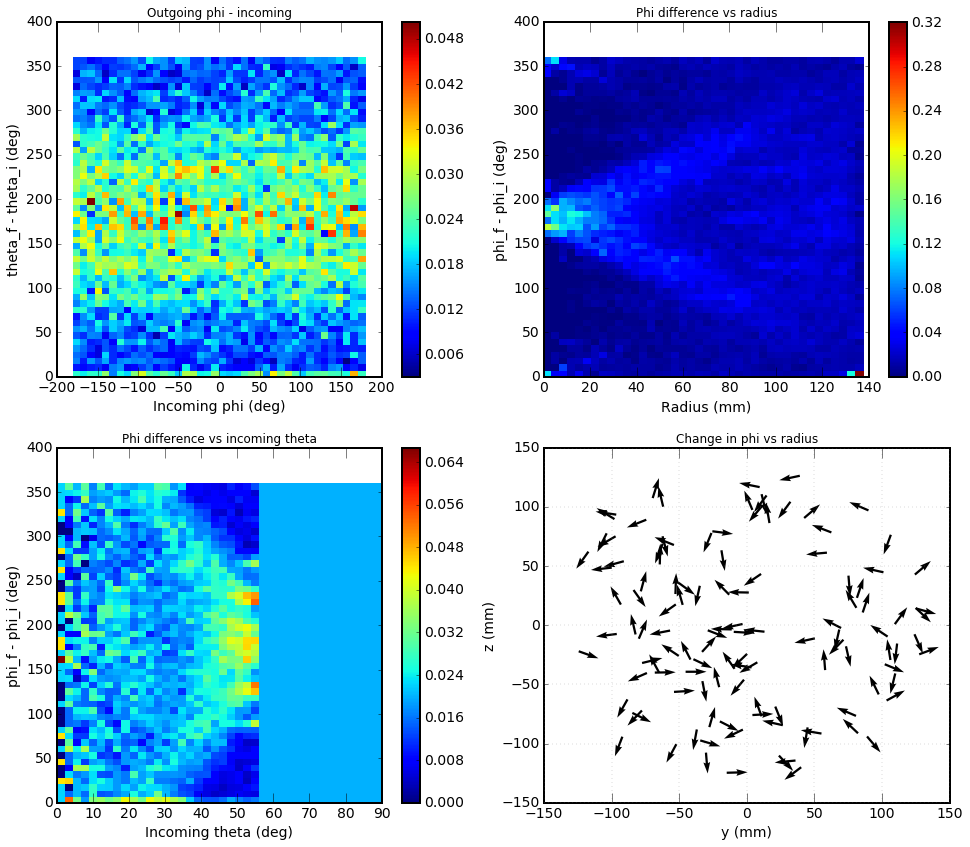

In [153]:
# Let's plot the outgoing theta as a function of incoming theta
sel=( np.array([True]*len(data['y']))
     *(data['theta_i'] < np.deg2rad(55.))
     #*(data['z'] > 0)
     #*(data['r']>0)
    )
plotReflections(data,sel)


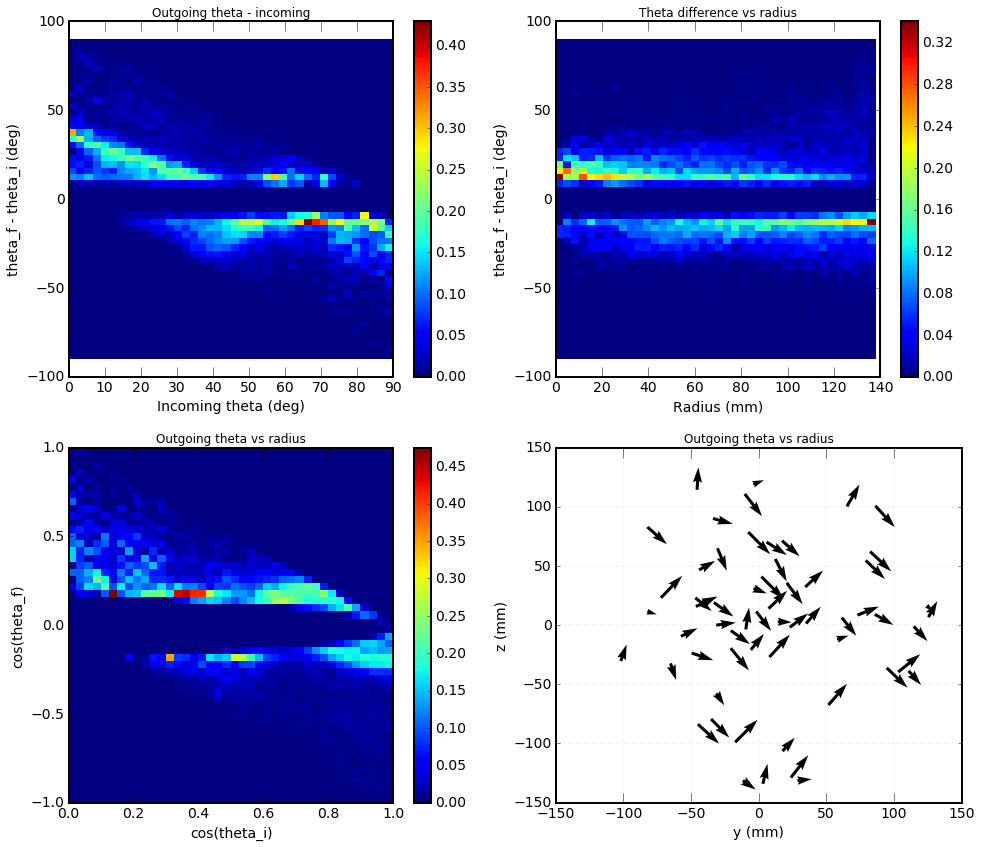

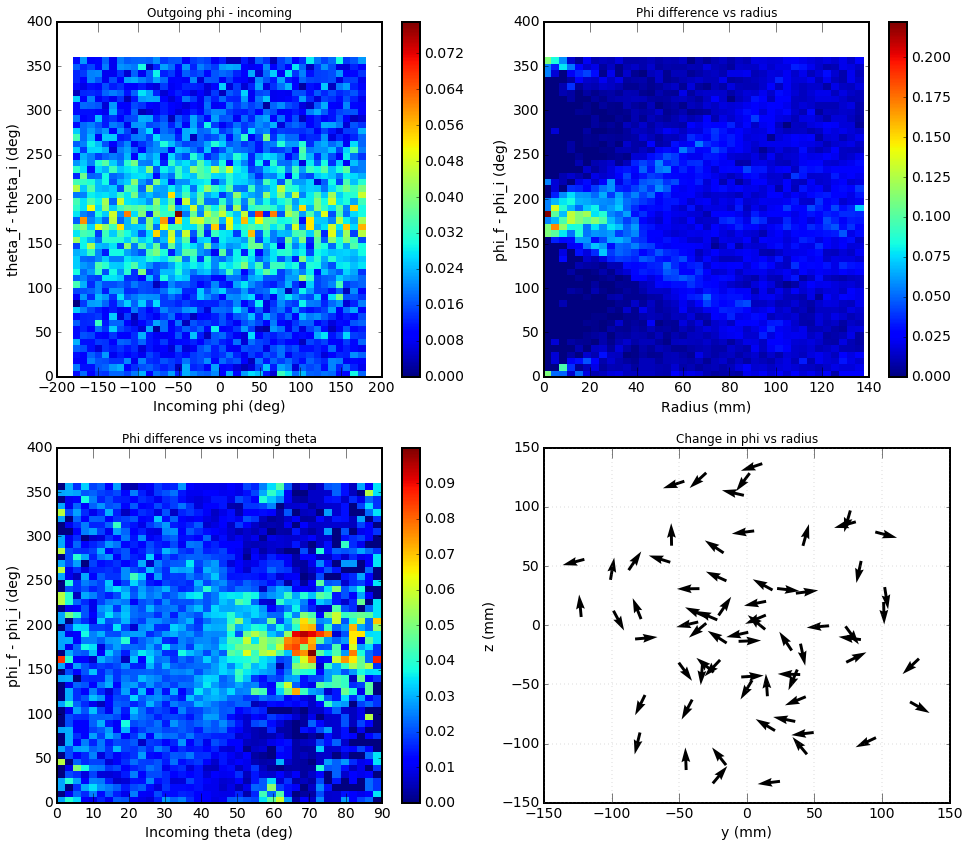

In [154]:
# Let's plot the outgoing theta as a function of incoming theta
sel=( np.array([True]*len(data['y']))
     *(np.abs(data['theta_f']-data['theta_i']) > np.deg2rad(10.))
     #*(data['z'] > 0)
     #*(data['r']>0)
    )
plotReflections(data,sel)

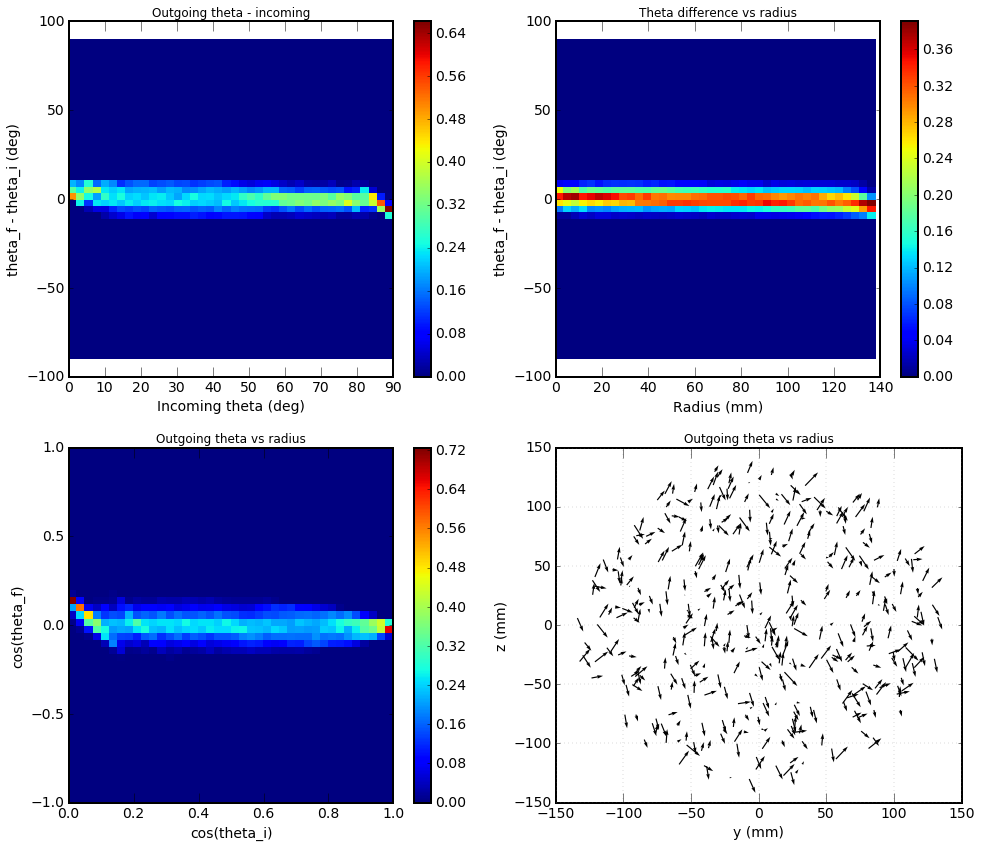

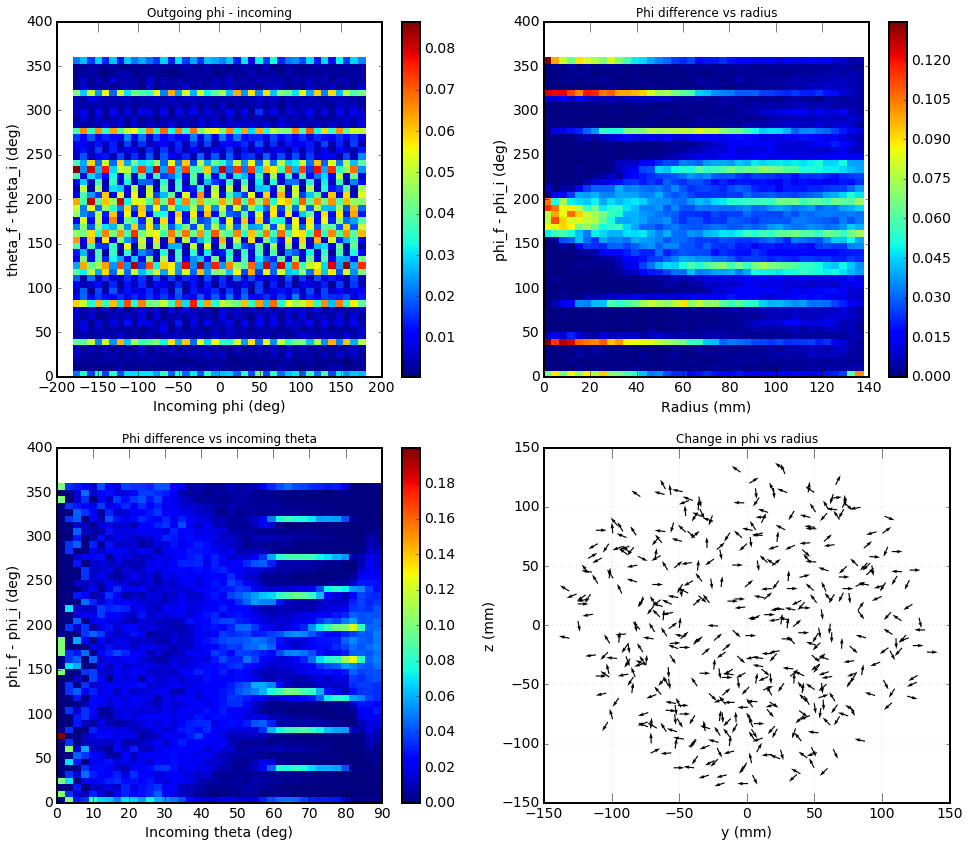

In [155]:
# Let's plot the outgoing theta as a function of incoming theta
sel=( np.array([True]*len(data['y']))
     *(np.abs(data['theta_f']-data['theta_i']) < np.deg2rad(10.))
     #*(data['z'] > 0)
     #*(data['r']>0)
    )
plotReflections(data,sel)

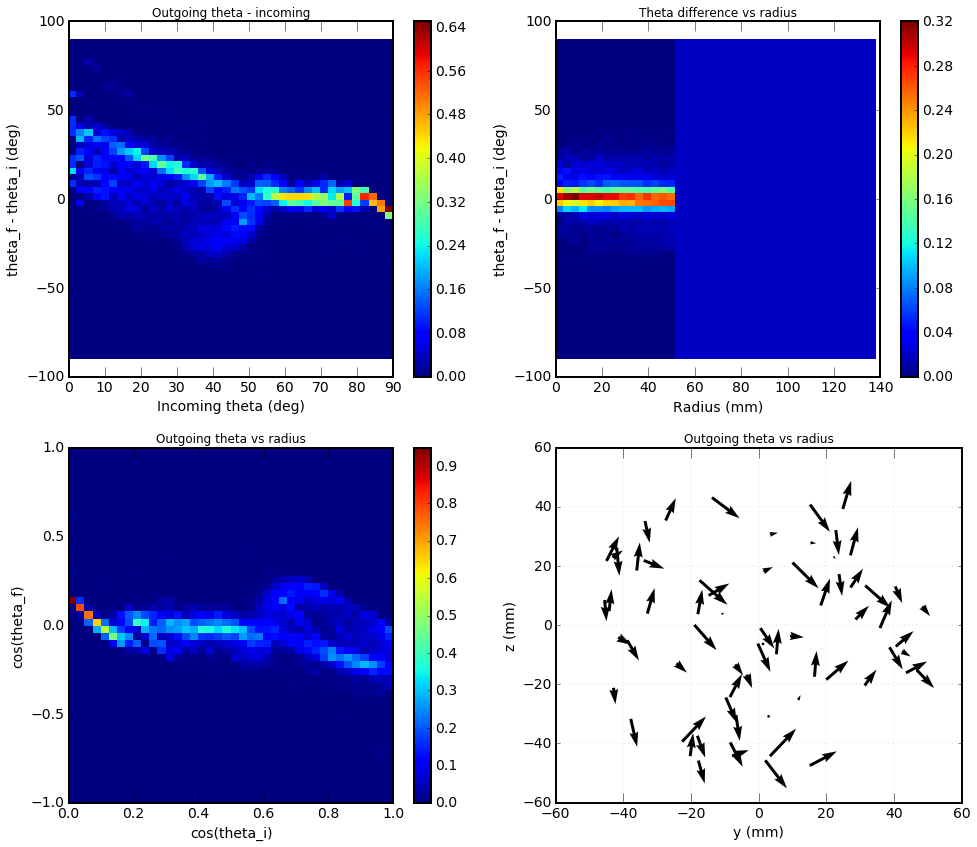

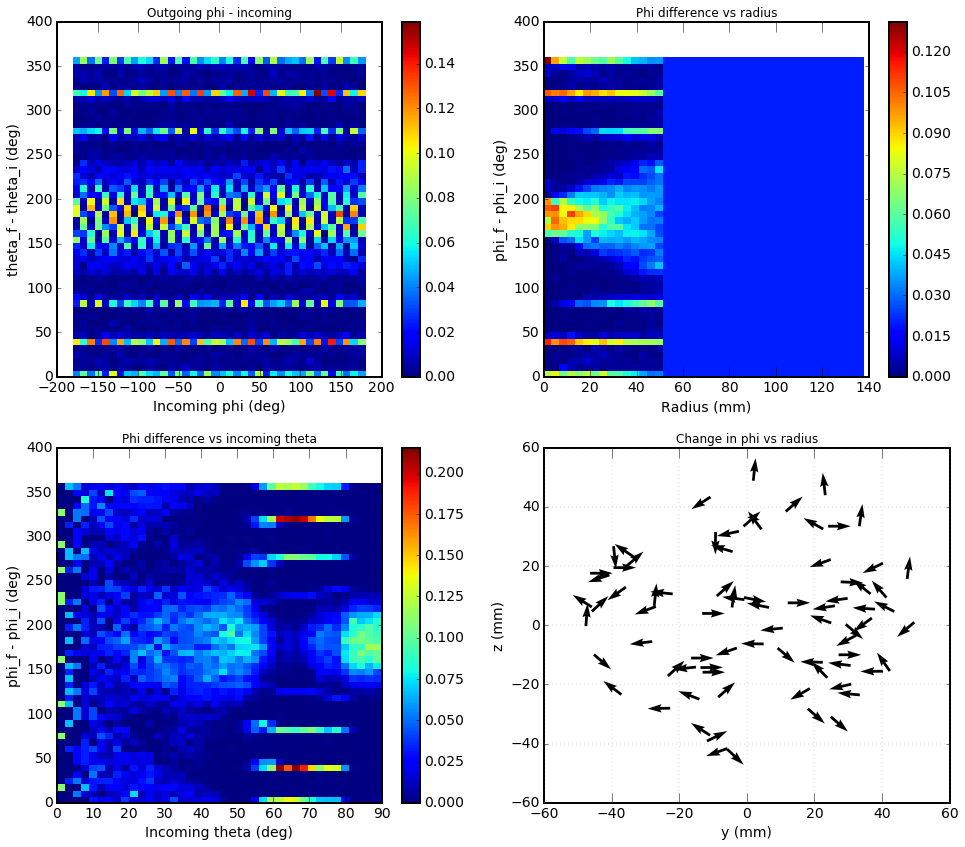

In [156]:
# Let's plot the outgoing theta as a function of incoming theta
sel=( np.array([True]*len(data['y']))
     #*(data['z'] > 0)
     *(data['r']<50)
    )
plotReflections(data,sel)

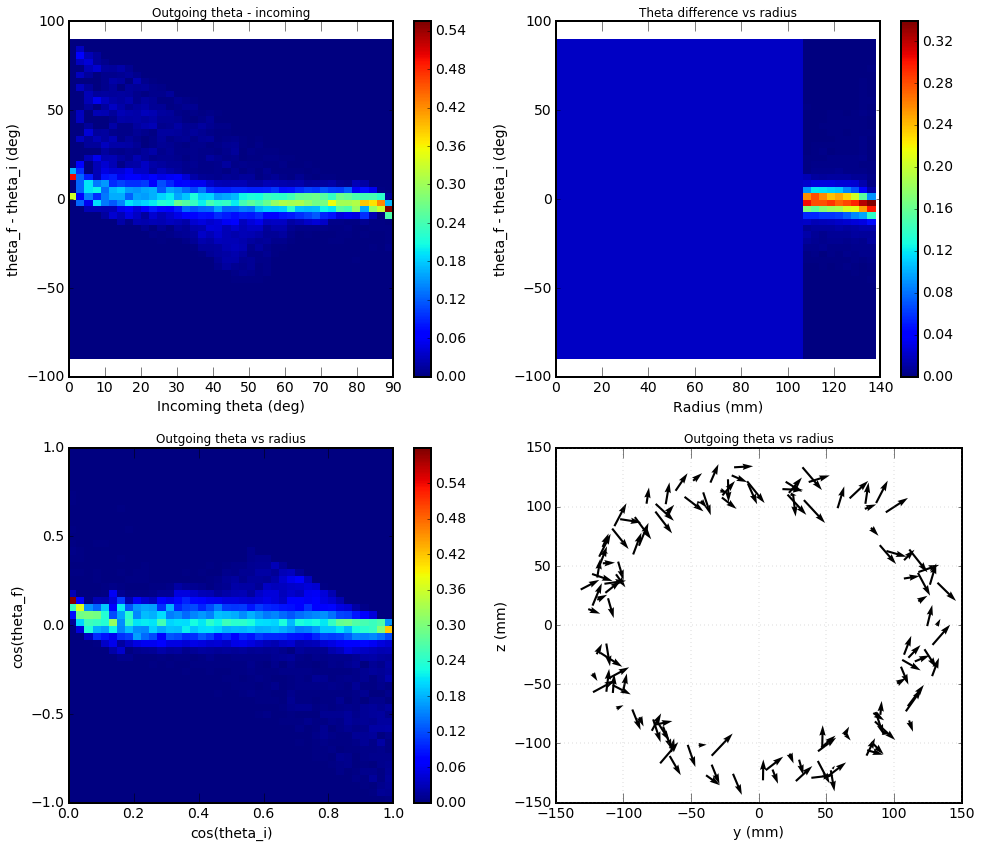

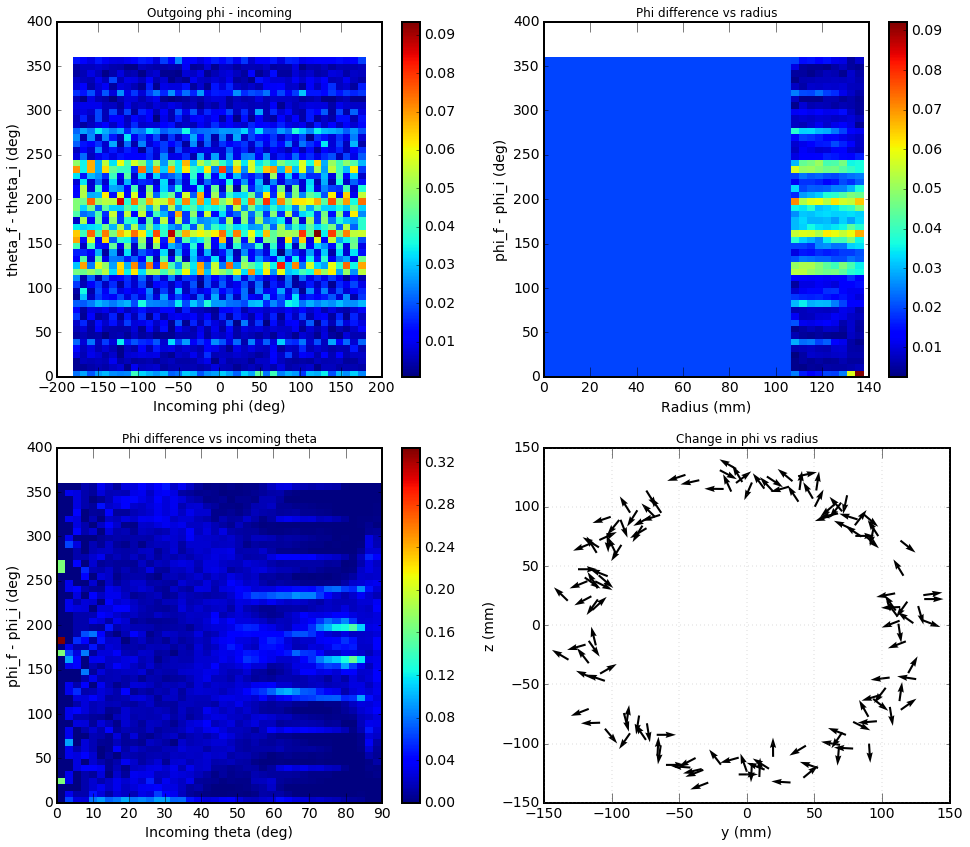

In [157]:
# Let's plot the outgoing theta as a function of incoming theta
sel=( np.array([True]*len(data['y']))
     #*(data['z'] > 0)
     *(data['r']>110)
    )
plotReflections(data,sel)

### Studying individual regions (hunch)

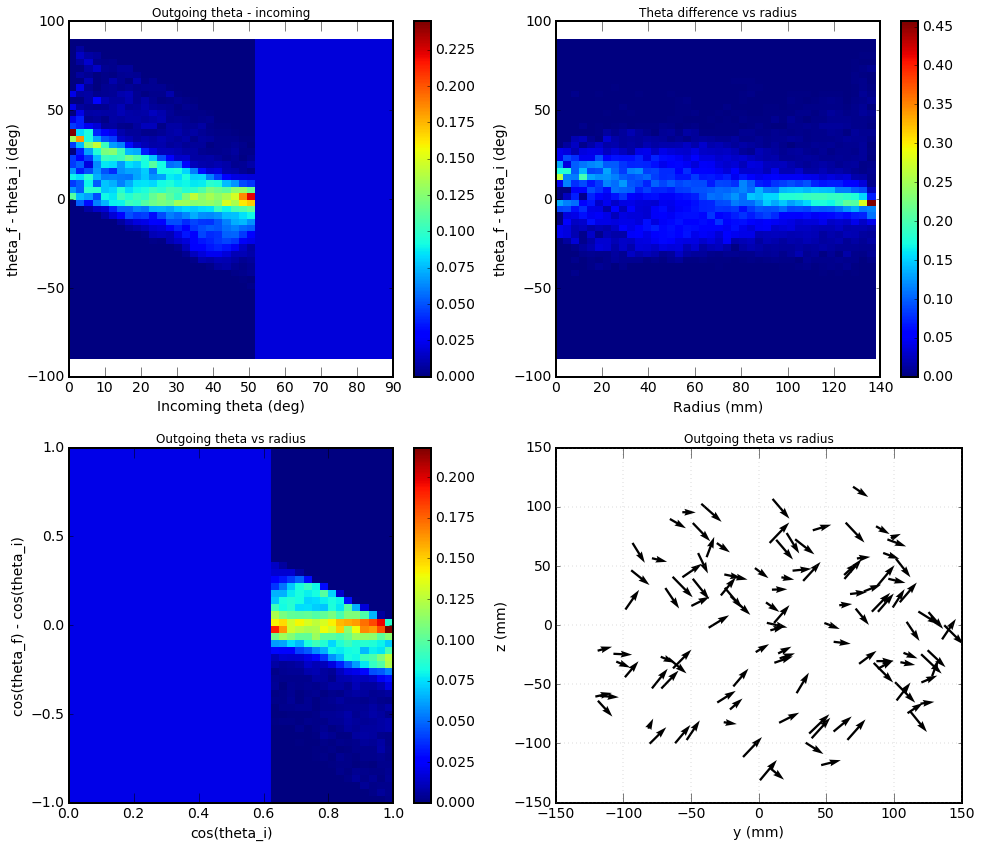

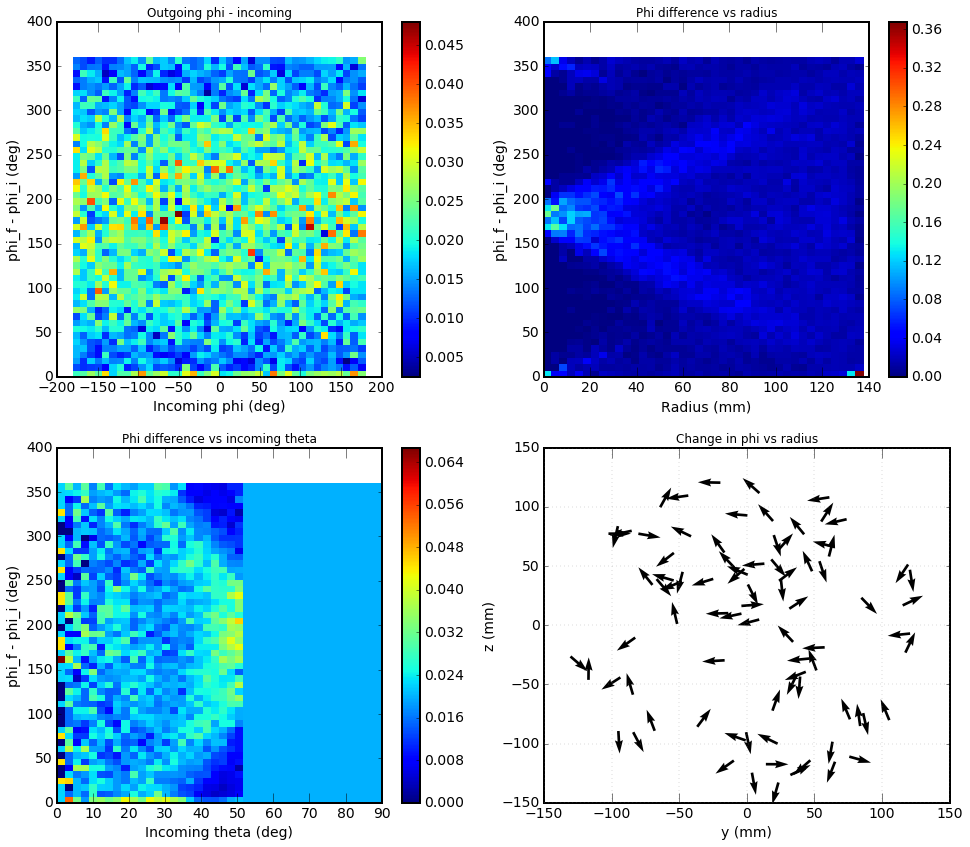

In [318]:
# Let's plot the outgoing theta as a function of incoming theta
sel=( np.array([True]*len(data['y']))
     #*(data['z'] > 0)
     #*(data['r']<60)
     *(data['theta_i']<np.deg2rad(50.))
    )
plotReflections(data,sel)

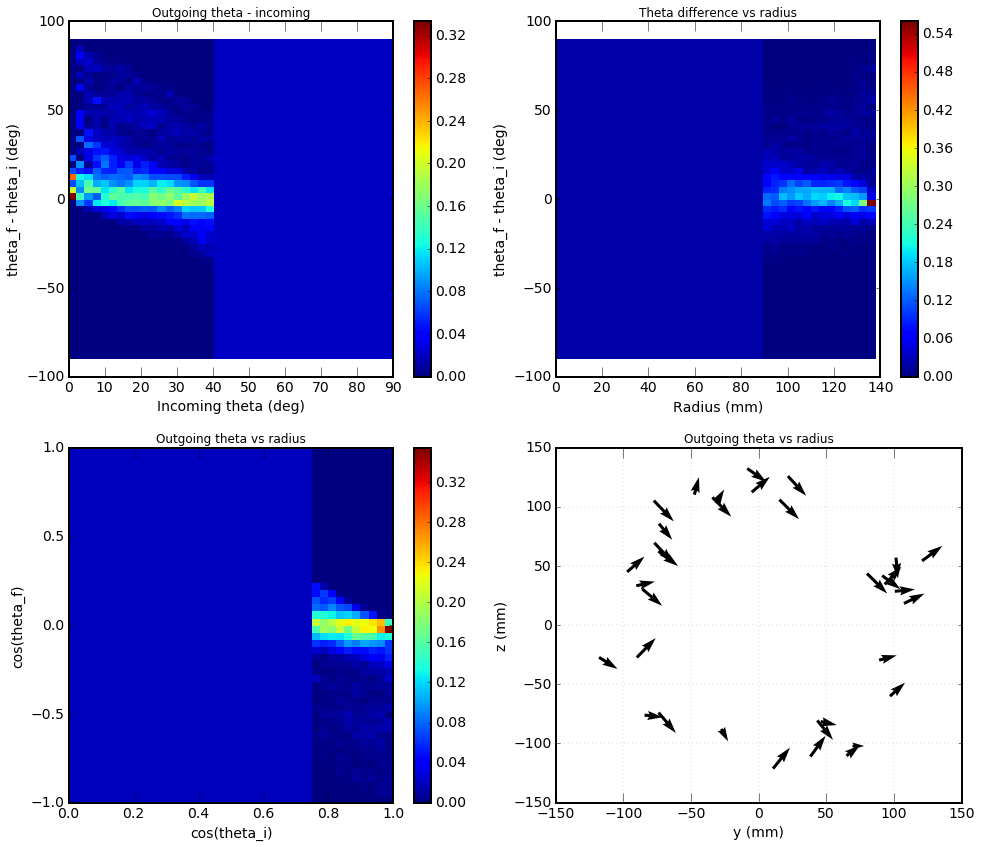

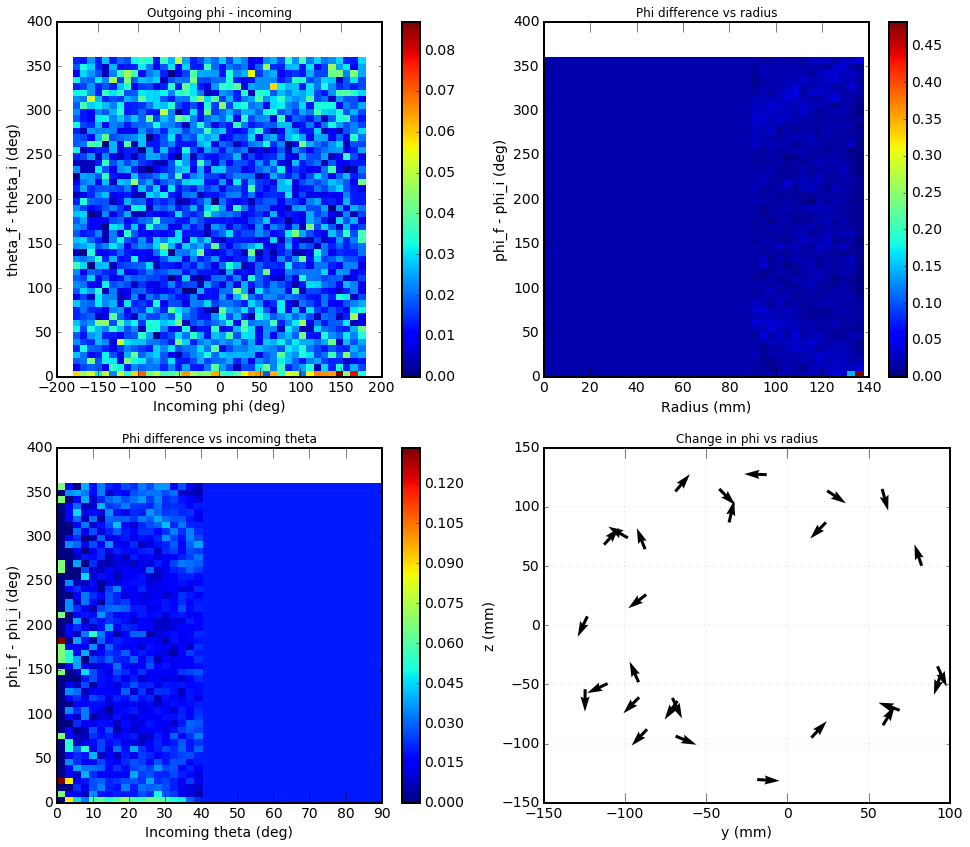

In [159]:
# Let's plot the outgoing theta as a function of incoming theta
sel=( np.array([True]*len(data['y']))
     #*(data['z'] > 0)
     *(data['r']>90)
     *(data['theta_i']<np.deg2rad(40.))
    )
plotReflections(data,sel)

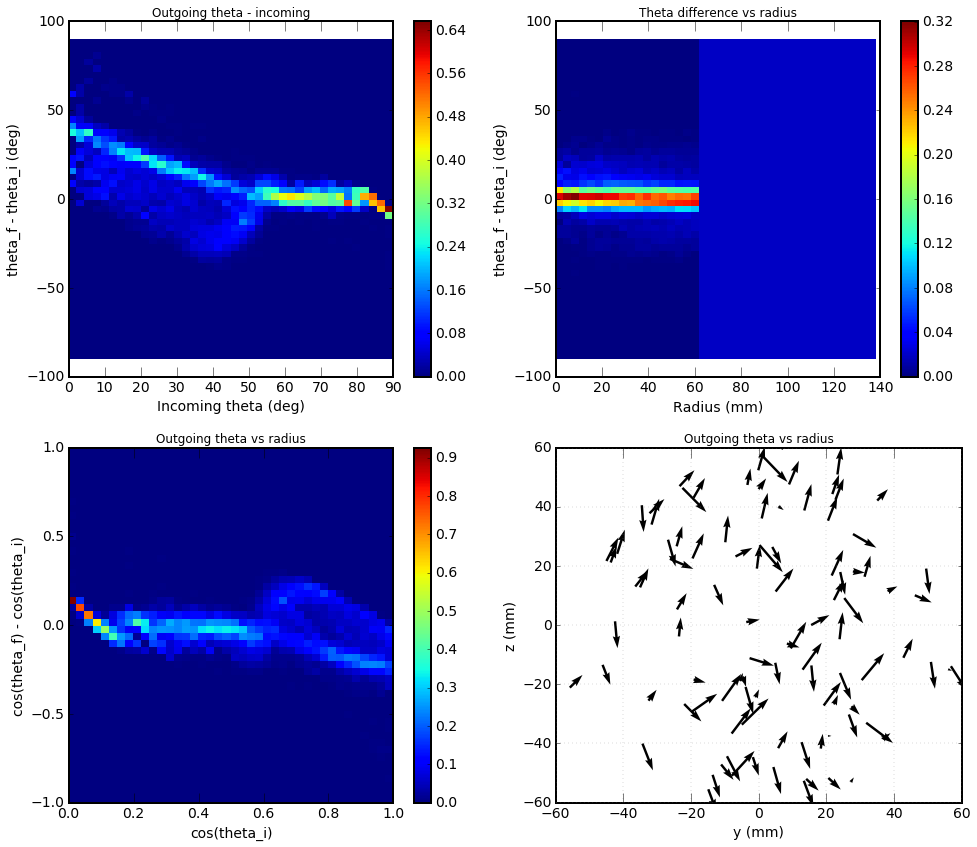

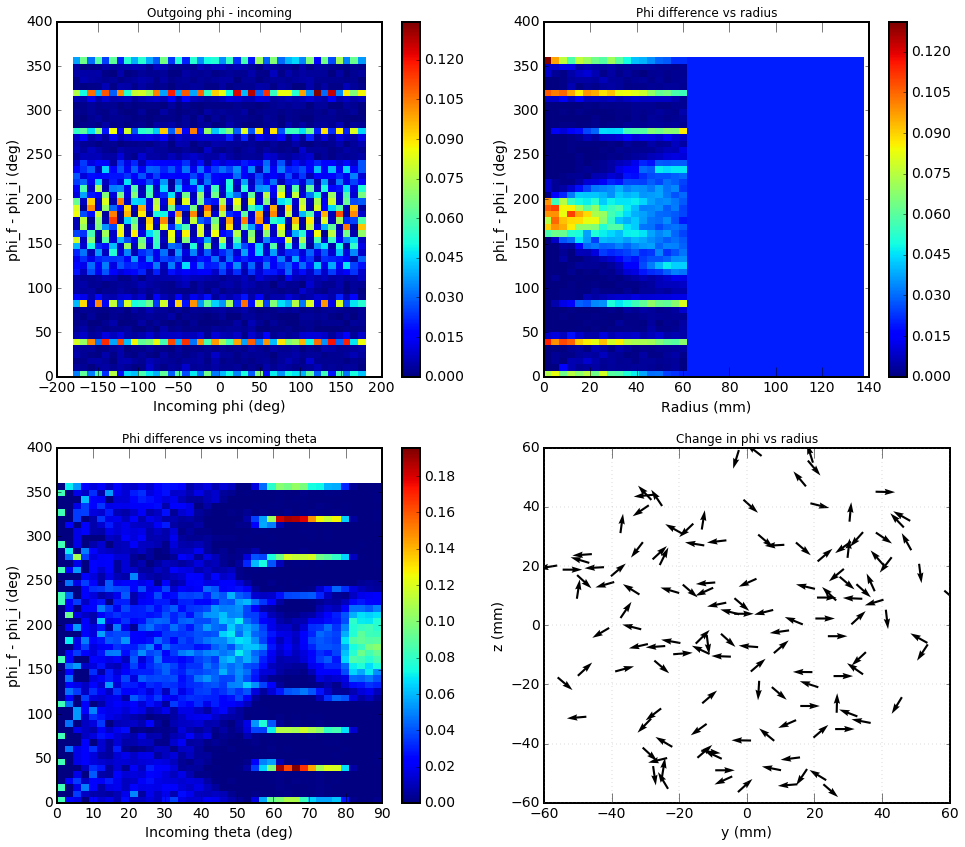

In [313]:
# Let's plot the outgoing theta as a function of incoming theta
sel=( np.array([True]*len(data['y']))
     #*(data['z'] > 0)
     *(data['r']<60)
     #*(data['theta_i']>np.deg2rad(50.))
    )
plotReflections(data,sel)

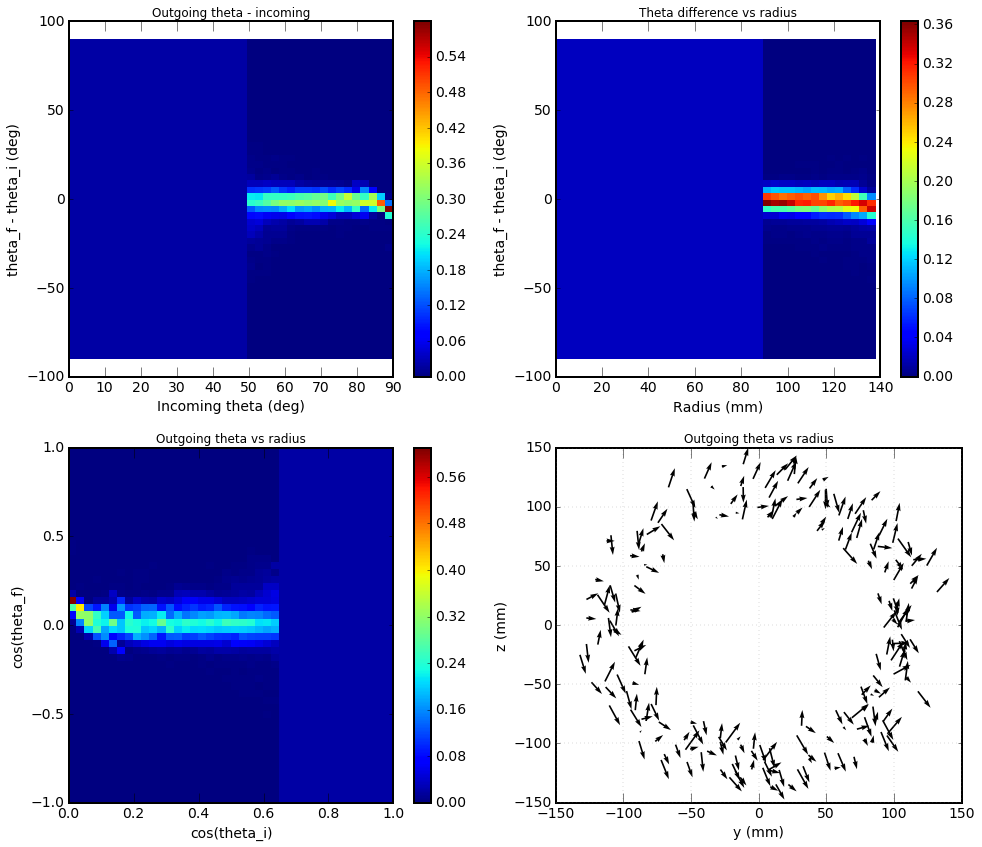

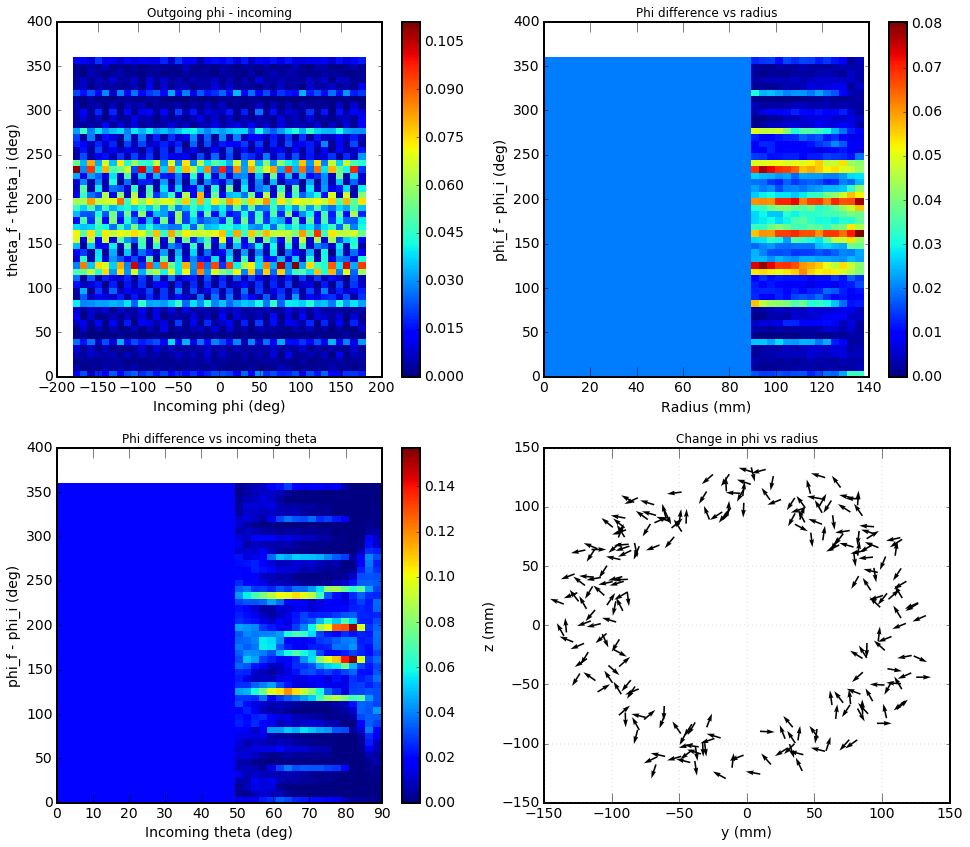

In [163]:
# Let's plot the outgoing theta as a function of incoming theta
sel=( np.array([True]*len(data['y']))
     #*(data['z'] > 0)
     *(data['r']>90)
     *(data['theta_i']>np.deg2rad(50.))
    )
plotReflections(data,sel)

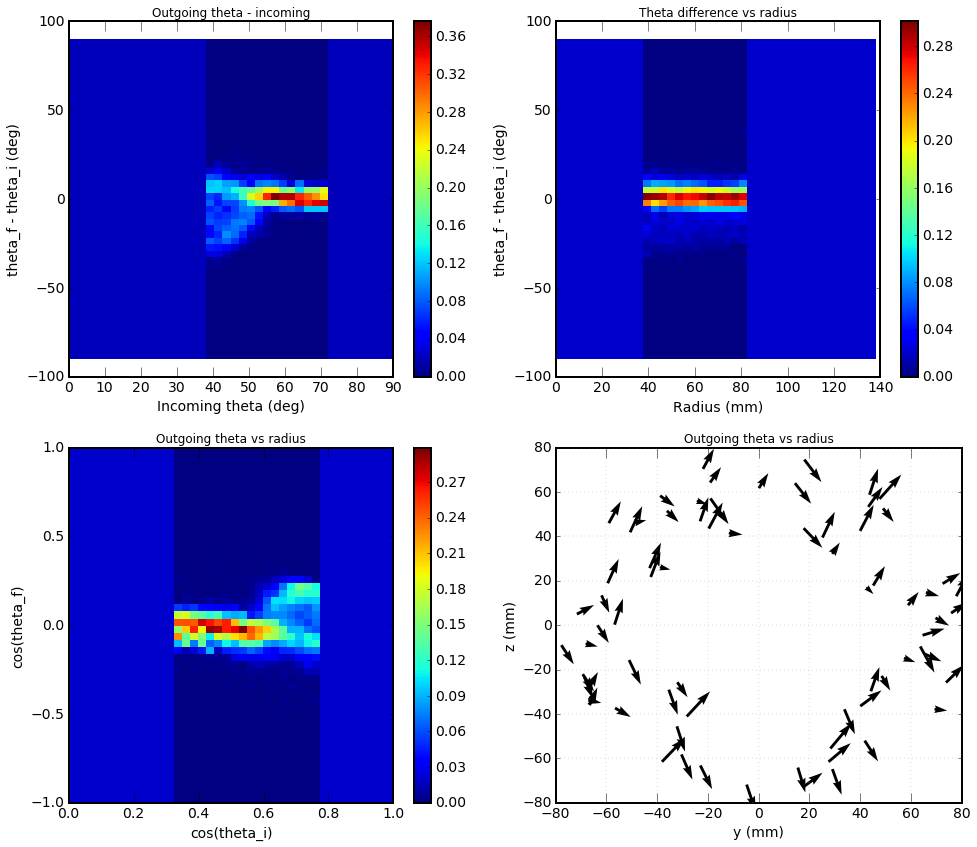

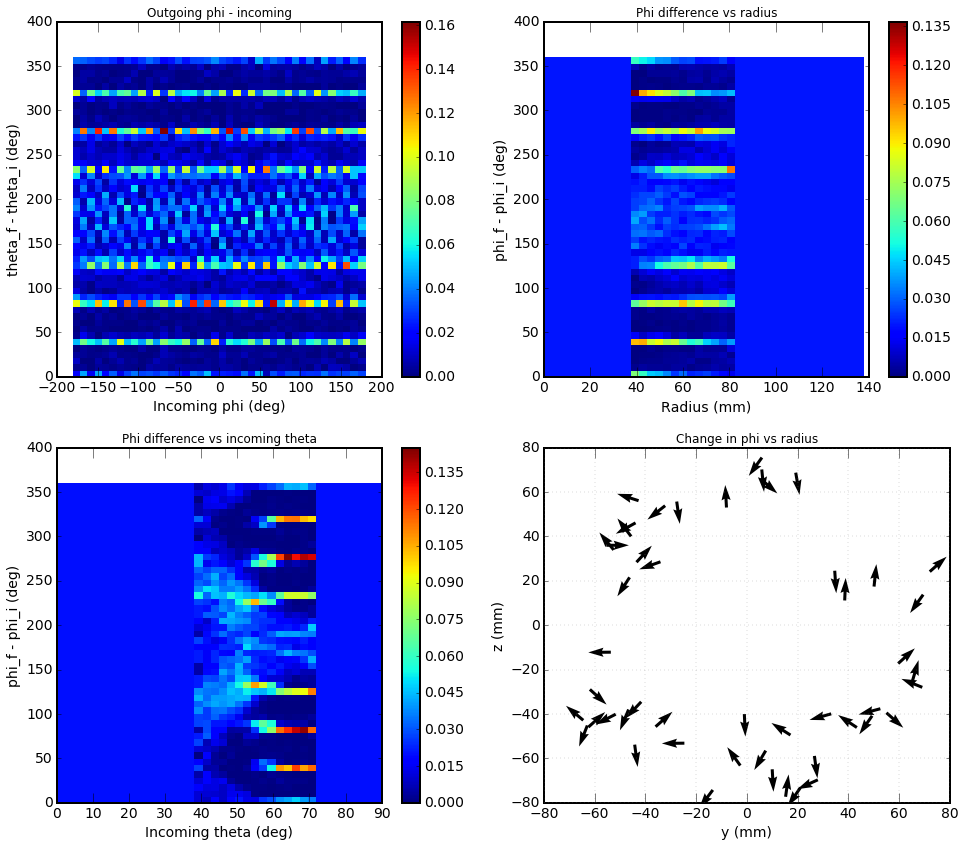

In [164]:
# Medium region
sel=( np.array([True]*len(data['y']))
     #*(data['z'] > 0)
     *(data['r']>40)
     *(data['r']<80)
     *(data['theta_i']>np.deg2rad(40.))
     *(data['theta_i']<np.deg2rad(70.))
    )
plotReflections(data,sel)

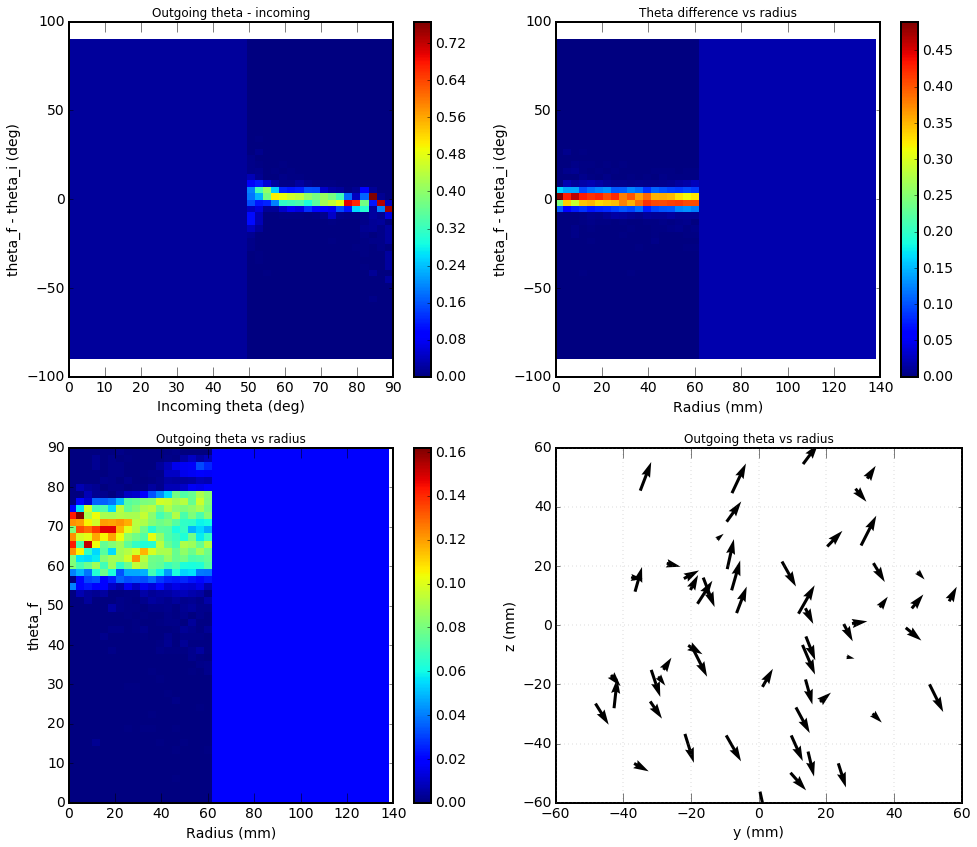

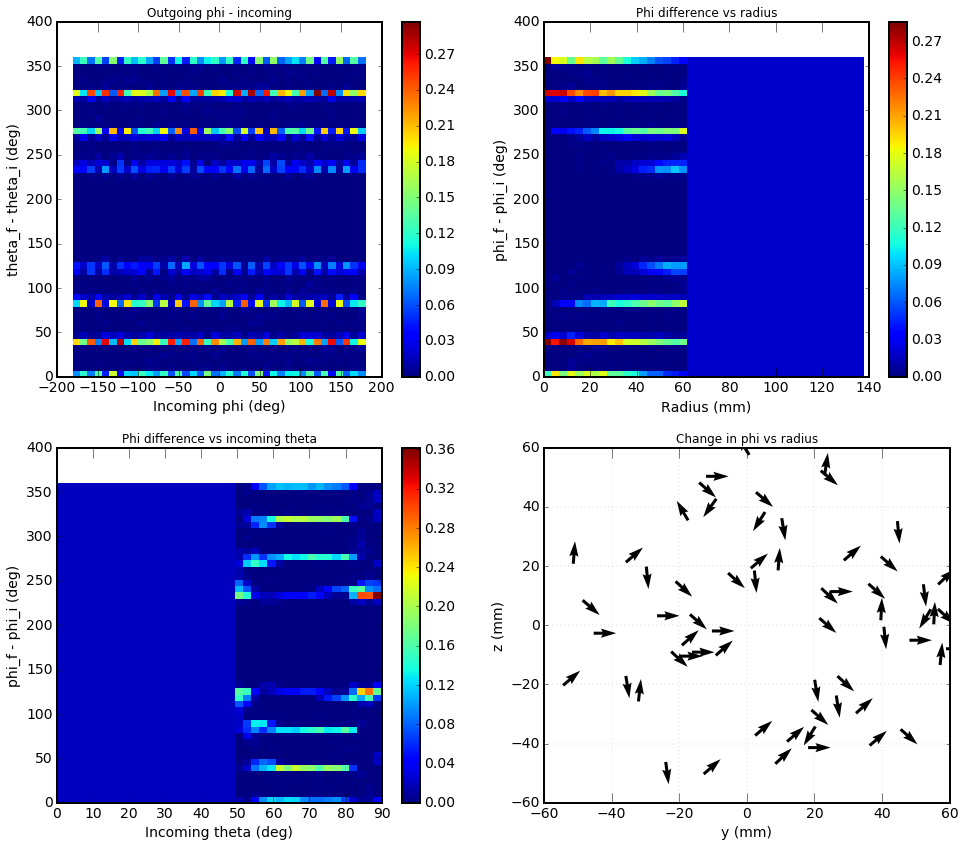

In [137]:
# Exploring the phi modes
# Let's plot the outgoing theta as a function of incoming theta
sel=( np.array([True]*len(data['y']))
     #*(data['z'] > 0)
     *(data['r']<60)
     *(data['theta_i']>np.deg2rad(50.))
     *(np.abs(data['phidiff']-np.pi)>np.deg2rad(50.))
    )
plotReflections(data,sel)

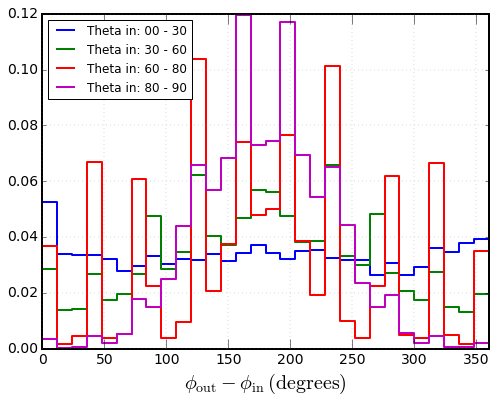

In [327]:
colors = cycle(['b','g','r','m','c'])
#xaxis = np.linspace(-2,2, 41)
xaxis = np.linspace(0,360, 31)
plt.figure(figsize=(8,6))
inregions = [0,  30, 60, 80, 90]
for i in range(len(inregions)-1):
    
    sel=( np.array([True]*len(data['y']))
         *(data['theta_i'] > np.deg2rad(inregions[i]))
         *(data['theta_i'] < np.deg2rad(inregions[i+1]))
         #*(data['z'] > 0)
         #*(data['r']>0)
        )    
    


    thisdata = np.rad2deg(data['phidiff'])[sel]
    #thisdata = np.rad2deg(data['theta_f'] - data['theta_i'])[sel]

    
    #print thisdata.min(), thisdata.max()
    bins, x = np.histogram(thisdata, xaxis)
    #print 'Mean', thisdata.mean(), 'std', thisdata.std()
    #tmpdata = np.concatenate((thisdata[thisdata>0], -1.*thisdata[thisdata>0]))
    #print 'STD2', tmpdata.std()
    
    # Fitting two gaussians
    #p0 = [0.15, 0, 8]
    fit_fcn = gaus
    xfit = np.array([0.5 * (x[k] + x[k + 1]) for k in range(len(bins))])
    
    
    bins = bins*1./np.sum(bins)
    
    #popt, pcov = optimize.curve_fit(fit_fcn, xfit, bins, p0 = p0)
    
    #print '\nMu1', popt[1], 'std1', popt[2]
    #print 'Mu2', popt[4], 'std2', popt[5]
    #print popt
    
    thiscolor= colors.next()
    
    #plt.plot(x, fit_fcn(x, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5]),
    #         color=thiscolor, linestyle = '--')
    
    jplot.unfilledBar(x, bins, color=thiscolor, 
                      label = 'Theta in: %02i' % inregions[i] + ' - %02i' % inregions[i+1])
    
plt.legend(loc=0)
plt.xlabel(r'$\phi_\mathrm{out} - \phi_\mathrm{in}\,\mathrm{(degrees)}$', fontsize=20)